# Import dependencies

In [3]:
import datetime
import random
import os
import logging
import time
import tqdm
import itertools
import json
import glob
import multiprocessing as mp
import copy

import cv2
from matplotlib import pyplot as plt
import numpy as np
import torch
from torch.nn.parallel import DistributedDataParallel
from fvcore.common.timer import Timer
from fvcore.common.file_io import PathManager

import detectron2
from detectron2 import model_zoo
from detectron2.engine import (
    DefaultPredictor,
    DefaultTrainer,
    HookBase,
    SimpleTrainer,
    hooks,
)

from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.data.datasets import register_coco_instances
from detectron2.data import detection_utils as utils
from detectron2.data import transforms as T
from detectron2.data import (
    MetadataCatalog,
    DatasetCatalog,
    DatasetMapper,
    DatasetFromList,
    build_detection_train_loader,
    build_detection_test_loader,
)

from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger, log_every_n_seconds
from detectron2.evaluation import COCOEvaluator
from detectron2.modeling import build_model
from detectron2.solver import build_optimizer
from detectron2.utils import comm
from detectron2.utils.events import CommonMetricPrinter
from detectron2.utils.analysis import parameter_count_table
from demo.predictor import VisualizationDemo


setup_logger()
logger = logging.getLogger("detectron2")
os.environ["CUDA_VISIBLE_DEVICES"]="2,3"

# For Reproducibility

In [4]:
def seed_everything(seed: int):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Prepare dataset

In [5]:
# Register the coco instance
DATASET_NAME = "midv"
DATASET_SRC = "/data/card-segmentation/midv/"

for d in ["train", "val"]:
    register_coco_instances(
        f"{DATASET_NAME}_{d}",
        {},
        f"{DATASET_SRC}{DATASET_NAME}_{d}.json",
        f"{DATASET_SRC}",
    )

# Create metadata for train ,and val dataset
train_metadata = MetadataCatalog.get(f"{DATASET_NAME}_train")
train_dataset_dicts = DatasetCatalog.get(f"{DATASET_NAME}_train")

val_metadata = MetadataCatalog.get(f"{DATASET_NAME}_val")
val_dataset_dicts = DatasetCatalog.get(f"{DATASET_NAME}_val")

[07/28 02:44:24 d2.data.datasets.coco]: Loaded 16441 images in COCO format from /data/card-segmentation/midv/midv_train.json
[07/28 02:44:24 d2.data.datasets.coco]: Loaded 2030 images in COCO format from /data/card-segmentation/midv/midv_val.json


# Visualize the dataset

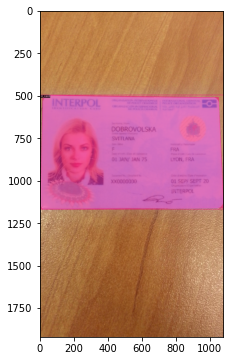

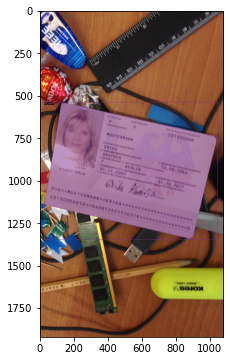

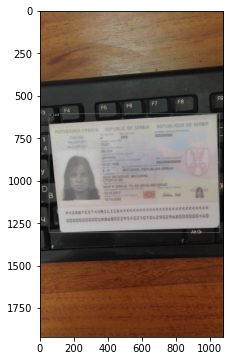

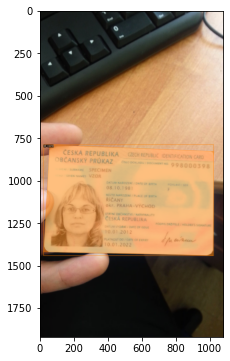

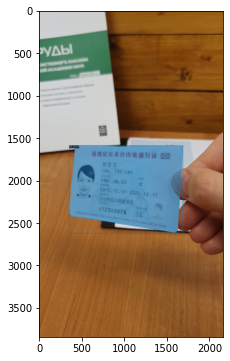

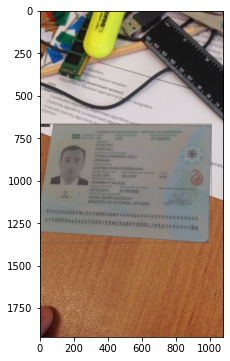

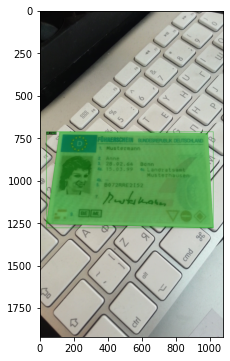

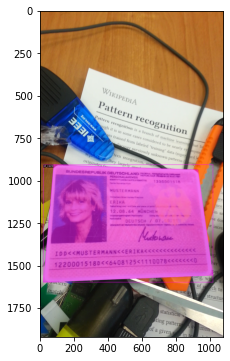

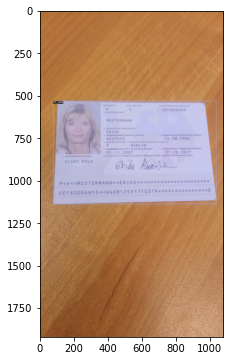

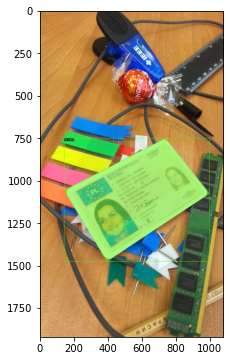

In [6]:
def visualize(dataset, metadata, size):
    for d in random.sample(dataset, size):
        img = cv2.imread(d["file_name"])
        v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1)
        v = v.draw_dataset_dict(d)
        plt.figure(figsize=(10, 6))
        plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
        plt.show()


visualize(train_dataset_dicts, train_metadata, 5)
visualize(val_dataset_dicts, val_metadata, 5)

# Model training

## Define customize trainer for monitoning validation loss

In [7]:
def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")

    transform_list = [
        T.RandomFlip(prob=0.5, horizontal=True, vertical=False),
        T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
        T.RandomRotation(angle=15),
        T.ResizeShortestEdge(
            short_edge_length=(640, 672, 704, 736, 768, 800),
            max_size=1333,
            sample_style="choice",
        ),
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)

    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))
    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
    ]

    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict


class LossEvalHook(HookBase):
    def __init__(self, eval_period, model, data_loader):
        self._model = model
        self._period = eval_period
        self._data_loader = data_loader

    def _do_loss_eval(self):
        # Copying inference_on_dataset from evaluator.py
        total = len(self._data_loader)
        num_warmup = min(5, total - 1)

        start_time = time.perf_counter()
        total_compute_time = 0
        losses = []
        for idx, inputs in enumerate(self._data_loader):
            if idx == num_warmup:
                start_time = time.perf_counter()
                total_compute_time = 0
            start_compute_time = time.perf_counter()
            if torch.cuda.is_available():
                torch.cuda.synchronize()
            total_compute_time += time.perf_counter() - start_compute_time
            iters_after_start = idx + 1 - num_warmup * int(idx >= num_warmup)
            seconds_per_img = total_compute_time / iters_after_start
            if idx >= num_warmup * 2 or seconds_per_img > 5:
                total_seconds_per_img = (
                    time.perf_counter() - start_time
                ) / iters_after_start
                eta = datetime.timedelta(
                    seconds=int(total_seconds_per_img * (total - idx - 1))
                )
                log_every_n_seconds(
                    logging.INFO,
                    "Loss on Validation  done {}/{}. {:.4f} s / img. ETA={}".format(
                        idx + 1, total, seconds_per_img, str(eta)
                    ),
                    n=5,
                )
            loss_batch = self._get_loss(inputs)
            losses.append(loss_batch)
        mean_loss = np.mean(losses)
        self.trainer.storage.put_scalar("validation_loss", mean_loss)
        comm.synchronize()

        return losses

    def _get_loss(self, data):
        metrics_dict = self._model(data)
        metrics_dict = {
            k: v.detach().cpu().item() if isinstance(v, torch.Tensor) else float(v)
            for k, v in metrics_dict.items()
        }
        total_losses_reduced = sum(loss for loss in metrics_dict.values())
        return total_losses_reduced

    def after_step(self):
        next_iter = self.trainer.iter + 1
        is_final = next_iter == self.trainer.max_iter
        if is_final or (self._period > 0 and next_iter % self._period == 0):
            self._do_loss_eval()
        self.trainer.storage.put_scalars(timetest=12)


class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            output_folder = os.path.join(cfg.OUTPUT_DIR, "inference")
        return COCOEvaluator(dataset_name, cfg, True, output_folder)

    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

    def build_hooks(self):
        hooks = super().build_hooks()
        hooks.insert(
            -1,
            LossEvalHook(
                self.cfg.TEST.EVAL_PERIOD,
                self.model,
                build_detection_test_loader(
                    self.cfg, self.cfg.DATASETS.TEST[0], DatasetMapper(self.cfg, True)
                ),
            ),
        )
        return hooks

## Function for training with different models

In [8]:
def create_config(model_yaml: str, output_dir: str, num_classes: int):
    cfg = get_cfg()
    cfg.merge_from_file(model_zoo.get_config_file(model_yaml))

    cfg.DATASETS.TRAIN = (f"{DATASET_NAME}_train",)
    cfg.DATASETS.TEST = (f"{DATASET_NAME}_val",)
    cfg.TEST.EVAL_PERIOD = 2000
    cfg.DATALOADER.NUM_WORKERS = 2
    cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(model_yaml)
    cfg.OUTPUT_DIR = output_dir
    cfg.SOLVER.IMS_PER_BATCH = 1
    cfg.SOLVER.BASE_LR = 0.00025
    cfg.SOLVER.MAX_ITER = 10000
    cfg.MODEL.ROI_HEADS.NUM_CLASSES = num_classes
    return cfg


def start_training(config):
    os.makedirs(config.OUTPUT_DIR, exist_ok=True)
    trainer = CustomTrainer(config)
    trainer.resume_or_load(resume=False)
    trainer.train()

## Models for benchmark

In [9]:
seed_everything(seed=1234)
experiment_dir = "/data/card-segmentation/models"

models = {
    "R50C4_COCO": "COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x.yaml",
    "R50FPN_COCO": "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml",
    "R50DV5_COCO": "COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_3x.yaml",
}

models_config = {}
for model, yaml in models.items():
    output_dir = os.path.join(experiment_dir, model)
    config = create_config(model_yaml=yaml, output_dir=output_dir, num_classes=1)
    models_config[model] = config
    start_training(config)
    config.MODEL.WEIGHTS = os.path.join(config.OUTPUT_DIR, "model_final.pth")

    # Save the config
    path = os.path.join(output_dir, "config.yaml")
    with PathManager.open(path, "w") as f:
        f.write(config.dump())

WARNING [07/28 02:45:26 d2.modeling.backbone.resnet]: ResNet.make_stage(first_stride=) is deprecated!  Use 'stride_per_block' or 'stride' instead.
[07/28 02:45:32 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (

[07/28 02:45:32 d2.data.datasets.coco]: Loaded 16441 images in COCO format from /data/card-segmentation/midv/midv_train.json
[07/28 02:45:33 d2.data.build]: Removed 0 images with no usable annotations. 16441 images left.
[07/28 02:45:33 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|  id_card   | 16441        |
|            |              |
[07/28 02:45:33 d2.data.common]: Serializing 16441 elements to byte tensors and concatenating them all ...
[07/28 02:45:33 d2.data.common]: Serialized dataset takes 4.84 MiB
[07/28 02:45:33 d2.data.build]: Using training sampler TrainingSampler
[07/28 02:45:33 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[07/28 02:45:33 d2.data.datasets.coco]: Loaded 2030 images in COCO format from /data/card-segmentation/midv/midv_val.json
[07/28 02:45:3

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 2048) in the checkpoint but (2, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 2048) in the checkpoint but (4, 2048) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[07/28 02:45:34 d2.engine.train_loop]: Starting training from iteration 0
[07/28 02:45:45 d2.utils.events]:  eta: 1:29:27  iter: 19  total_loss: 1.681  loss_cls: 0.620  loss_box_reg: 0.200  loss_mask: 0.697  loss_rpn_cls: 0.079  loss_rpn_loc: 0.070  time: 0.5426  data_time: 0.0460  lr: 0.000005  max_mem: 2637M
[07/28 02:45:56 d2.utils.events]:  eta: 1:29:13  iter: 39  total_loss: 1.575  loss_cls: 0.509  loss_box_reg: 0.189  loss_mask: 0.689  loss_rpn_cls: 0.131  loss_rpn_loc: 0.070  time: 0.5397  data_time: 0.0033  lr: 0.000010  max_mem: 2637M
[07/28 02:46:07 d2.utils.events]:  eta: 1:29:30  iter: 59  total_loss: 1.437  loss_cls: 0.341  loss_box_reg: 0.195  loss_mask: 0.674  loss_rpn_cls: 0.113  loss_rpn_loc: 0.088  time: 0.5402  data_time: 0.0033  lr: 0.000015  max_mem: 2637M
[07/28 02:46:18 d2.utils.events]:  eta: 1:29:05  iter: 79  total_loss: 1.274  loss_cls: 0.262  loss_box_reg: 0.201  loss_mask: 0.646  loss_rpn_cls: 0.093  loss_rpn_loc: 0.067  time: 0.5386  data_time: 0.0032  lr:

[07/28 02:51:41 d2.utils.events]:  eta: 1:23:29  iter: 679  total_loss: 0.204  loss_cls: 0.026  loss_box_reg: 0.070  loss_mask: 0.046  loss_rpn_cls: 0.006  loss_rpn_loc: 0.037  time: 0.5374  data_time: 0.0033  lr: 0.000170  max_mem: 2637M
[07/28 02:51:51 d2.utils.events]:  eta: 1:23:19  iter: 699  total_loss: 0.178  loss_cls: 0.024  loss_box_reg: 0.063  loss_mask: 0.046  loss_rpn_cls: 0.008  loss_rpn_loc: 0.039  time: 0.5374  data_time: 0.0033  lr: 0.000175  max_mem: 2637M
[07/28 02:52:02 d2.utils.events]:  eta: 1:23:08  iter: 719  total_loss: 0.162  loss_cls: 0.022  loss_box_reg: 0.054  loss_mask: 0.043  loss_rpn_cls: 0.008  loss_rpn_loc: 0.036  time: 0.5374  data_time: 0.0032  lr: 0.000180  max_mem: 2637M
[07/28 02:52:13 d2.utils.events]:  eta: 1:22:58  iter: 739  total_loss: 0.148  loss_cls: 0.021  loss_box_reg: 0.049  loss_mask: 0.045  loss_rpn_cls: 0.009  loss_rpn_loc: 0.035  time: 0.5375  data_time: 0.0035  lr: 0.000185  max_mem: 2637M
[07/28 02:52:24 d2.utils.events]:  eta: 1:22

[07/28 02:57:34 d2.utils.events]:  eta: 1:17:18  iter: 1339  total_loss: 0.136  loss_cls: 0.019  loss_box_reg: 0.052  loss_mask: 0.030  loss_rpn_cls: 0.003  loss_rpn_loc: 0.037  time: 0.5362  data_time: 0.0033  lr: 0.000250  max_mem: 2637M
[07/28 02:57:45 d2.utils.events]:  eta: 1:17:06  iter: 1359  total_loss: 0.130  loss_cls: 0.016  loss_box_reg: 0.041  loss_mask: 0.035  loss_rpn_cls: 0.002  loss_rpn_loc: 0.035  time: 0.5362  data_time: 0.0037  lr: 0.000250  max_mem: 2637M
[07/28 02:57:56 d2.utils.events]:  eta: 1:16:53  iter: 1379  total_loss: 0.135  loss_cls: 0.019  loss_box_reg: 0.035  loss_mask: 0.035  loss_rpn_cls: 0.002  loss_rpn_loc: 0.035  time: 0.5361  data_time: 0.0033  lr: 0.000250  max_mem: 2637M
[07/28 02:58:06 d2.utils.events]:  eta: 1:16:42  iter: 1399  total_loss: 0.153  loss_cls: 0.019  loss_box_reg: 0.038  loss_mask: 0.041  loss_rpn_cls: 0.006  loss_rpn_loc: 0.044  time: 0.5360  data_time: 0.0035  lr: 0.000250  max_mem: 2637M
[07/28 02:58:17 d2.utils.events]:  eta: 

[07/28 03:03:27 d2.data.datasets.coco]: Loaded 2030 images in COCO format from /data/card-segmentation/midv/midv_val.json
[07/28 03:03:27 d2.data.common]: Serializing 2030 elements to byte tensors and concatenating them all ...
[07/28 03:03:27 d2.data.common]: Serialized dataset takes 0.60 MiB
[07/28 03:03:27 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/28 03:03:27 d2.evaluation.evaluator]: Start inference on 2030 images
[07/28 03:03:29 d2.evaluation.evaluator]: Inference done 11/2030. 0.1277 s / img. ETA=0:04:35
[07/28 03:03:34 d2.evaluation.evaluator]: Inference done 48/2030. 0.1210 s / img. ETA=0:04:31
[07/28 03:03:39 d2.evaluation.evaluator]: Inference done 84/2030. 0.1236 s / img. ETA=0:04:31
[07/28 03:03:44 d2.evaluation.evaluator]: Inference done 121/2030. 0.1225 s / img. ETA=0:04:25
[07/28 03:03:49 d2.evaluation.evaluator]: Inference done 157/2030. 0.1232 s / img. ETA=0:04:2

[07/28 03:08:50 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
Loading and preparing results...
DONE (t=0.23s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
COCOeval_opt.evaluate() finished in 0.87 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.874
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.984
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.984
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.874
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.892
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all 

[07/28 03:13:49 detectron2]: Loss on Validation  done 1570/2030. 0.0000 s / img. ETA=0:01:27
[07/28 03:13:54 detectron2]: Loss on Validation  done 1595/2030. 0.0000 s / img. ETA=0:01:22
[07/28 03:13:59 detectron2]: Loss on Validation  done 1620/2030. 0.0000 s / img. ETA=0:01:17
[07/28 03:14:04 detectron2]: Loss on Validation  done 1645/2030. 0.0000 s / img. ETA=0:01:13
[07/28 03:14:10 detectron2]: Loss on Validation  done 1670/2030. 0.0000 s / img. ETA=0:01:08
[07/28 03:14:15 detectron2]: Loss on Validation  done 1695/2030. 0.0000 s / img. ETA=0:01:03
[07/28 03:14:20 detectron2]: Loss on Validation  done 1720/2030. 0.0000 s / img. ETA=0:00:59
[07/28 03:14:25 detectron2]: Loss on Validation  done 1745/2030. 0.0000 s / img. ETA=0:00:54
[07/28 03:14:30 detectron2]: Loss on Validation  done 1769/2030. 0.0000 s / img. ETA=0:00:49
[07/28 03:14:35 detectron2]: Loss on Validation  done 1794/2030. 0.0000 s / img. ETA=0:00:45
[07/28 03:14:40 detectron2]: Loss on Validation  done 1819/2030. 0.000

[07/28 03:19:30 d2.utils.events]:  eta: 1:07:06  iter: 2459  total_loss: 0.116  loss_cls: 0.014  loss_box_reg: 0.033  loss_mask: 0.028  loss_rpn_cls: 0.002  loss_rpn_loc: 0.037  validation_loss: 0.325  time: 0.5349  data_time: 0.0036  lr: 0.000250  max_mem: 2637M
[07/28 03:19:40 d2.utils.events]:  eta: 1:06:54  iter: 2479  total_loss: 0.112  loss_cls: 0.011  loss_box_reg: 0.030  loss_mask: 0.030  loss_rpn_cls: 0.002  loss_rpn_loc: 0.029  validation_loss: 0.325  time: 0.5349  data_time: 0.0033  lr: 0.000250  max_mem: 2637M
[07/28 03:19:51 d2.utils.events]:  eta: 1:06:43  iter: 2499  total_loss: 0.112  loss_cls: 0.014  loss_box_reg: 0.035  loss_mask: 0.033  loss_rpn_cls: 0.002  loss_rpn_loc: 0.030  validation_loss: 0.325  time: 0.5349  data_time: 0.0035  lr: 0.000250  max_mem: 2637M
[07/28 03:20:02 d2.utils.events]:  eta: 1:06:33  iter: 2519  total_loss: 0.113  loss_cls: 0.012  loss_box_reg: 0.033  loss_mask: 0.030  loss_rpn_cls: 0.003  loss_rpn_loc: 0.031  validation_loss: 0.325  time: 

[07/28 03:25:00 d2.utils.events]:  eta: 1:01:29  iter: 3079  total_loss: 0.112  loss_cls: 0.013  loss_box_reg: 0.029  loss_mask: 0.026  loss_rpn_cls: 0.001  loss_rpn_loc: 0.034  validation_loss: 0.325  time: 0.5343  data_time: 0.0035  lr: 0.000250  max_mem: 2637M
[07/28 03:25:11 d2.utils.events]:  eta: 1:01:18  iter: 3099  total_loss: 0.099  loss_cls: 0.017  loss_box_reg: 0.032  loss_mask: 0.026  loss_rpn_cls: 0.001  loss_rpn_loc: 0.024  validation_loss: 0.325  time: 0.5344  data_time: 0.0037  lr: 0.000250  max_mem: 2637M
[07/28 03:25:22 d2.utils.events]:  eta: 1:01:07  iter: 3119  total_loss: 0.098  loss_cls: 0.013  loss_box_reg: 0.029  loss_mask: 0.027  loss_rpn_cls: 0.003  loss_rpn_loc: 0.018  validation_loss: 0.325  time: 0.5343  data_time: 0.0034  lr: 0.000250  max_mem: 2637M
[07/28 03:25:32 d2.utils.events]:  eta: 1:00:56  iter: 3139  total_loss: 0.106  loss_cls: 0.011  loss_box_reg: 0.029  loss_mask: 0.025  loss_rpn_cls: 0.002  loss_rpn_loc: 0.033  validation_loss: 0.325  time: 

[07/28 03:30:32 d2.utils.events]:  eta: 0:56:00  iter: 3699  total_loss: 0.092  loss_cls: 0.010  loss_box_reg: 0.027  loss_mask: 0.025  loss_rpn_cls: 0.002  loss_rpn_loc: 0.026  validation_loss: 0.325  time: 0.5342  data_time: 0.0034  lr: 0.000250  max_mem: 2637M
[07/28 03:30:42 d2.utils.events]:  eta: 0:55:49  iter: 3719  total_loss: 0.108  loss_cls: 0.013  loss_box_reg: 0.033  loss_mask: 0.026  loss_rpn_cls: 0.002  loss_rpn_loc: 0.030  validation_loss: 0.325  time: 0.5342  data_time: 0.0035  lr: 0.000250  max_mem: 2637M
[07/28 03:30:53 d2.utils.events]:  eta: 0:55:39  iter: 3739  total_loss: 0.101  loss_cls: 0.009  loss_box_reg: 0.027  loss_mask: 0.027  loss_rpn_cls: 0.003  loss_rpn_loc: 0.030  validation_loss: 0.325  time: 0.5342  data_time: 0.0034  lr: 0.000250  max_mem: 2637M
[07/28 03:31:04 d2.utils.events]:  eta: 0:55:28  iter: 3759  total_loss: 0.108  loss_cls: 0.012  loss_box_reg: 0.027  loss_mask: 0.027  loss_rpn_cls: 0.003  loss_rpn_loc: 0.037  validation_loss: 0.325  time: 

[07/28 03:36:06 d2.evaluation.evaluator]: Inference done 1197/2030. 0.1320 s / img. ETA=0:02:00
[07/28 03:36:11 d2.evaluation.evaluator]: Inference done 1231/2030. 0.1321 s / img. ETA=0:01:56
[07/28 03:36:16 d2.evaluation.evaluator]: Inference done 1266/2030. 0.1321 s / img. ETA=0:01:50
[07/28 03:36:21 d2.evaluation.evaluator]: Inference done 1301/2030. 0.1322 s / img. ETA=0:01:45
[07/28 03:36:26 d2.evaluation.evaluator]: Inference done 1337/2030. 0.1321 s / img. ETA=0:01:40
[07/28 03:36:31 d2.evaluation.evaluator]: Inference done 1371/2030. 0.1322 s / img. ETA=0:01:35
[07/28 03:36:36 d2.evaluation.evaluator]: Inference done 1409/2030. 0.1319 s / img. ETA=0:01:29
[07/28 03:36:41 d2.evaluation.evaluator]: Inference done 1445/2030. 0.1319 s / img. ETA=0:01:24
[07/28 03:36:46 d2.evaluation.evaluator]: Inference done 1473/2030. 0.1322 s / img. ETA=0:01:21
[07/28 03:36:51 d2.evaluation.evaluator]: Inference done 1496/2030. 0.1328 s / img. ETA=0:01:18
[07/28 03:36:56 d2.evaluation.evaluator]

[07/28 03:39:15 detectron2]: Loss on Validation  done 146/2030. 0.0001 s / img. ETA=0:05:52
[07/28 03:39:20 detectron2]: Loss on Validation  done 174/2030. 0.0001 s / img. ETA=0:05:46
[07/28 03:39:25 detectron2]: Loss on Validation  done 201/2030. 0.0001 s / img. ETA=0:05:42
[07/28 03:39:31 detectron2]: Loss on Validation  done 228/2030. 0.0001 s / img. ETA=0:05:37
[07/28 03:39:36 detectron2]: Loss on Validation  done 255/2030. 0.0001 s / img. ETA=0:05:32
[07/28 03:39:41 detectron2]: Loss on Validation  done 282/2030. 0.0001 s / img. ETA=0:05:28
[07/28 03:39:46 detectron2]: Loss on Validation  done 308/2030. 0.0001 s / img. ETA=0:05:24
[07/28 03:39:51 detectron2]: Loss on Validation  done 335/2030. 0.0001 s / img. ETA=0:05:19
[07/28 03:39:56 detectron2]: Loss on Validation  done 362/2030. 0.0001 s / img. ETA=0:05:14
[07/28 03:40:01 detectron2]: Loss on Validation  done 389/2030. 0.0001 s / img. ETA=0:05:09
[07/28 03:40:06 detectron2]: Loss on Validation  done 416/2030. 0.0001 s / img. 

[07/28 03:46:02 d2.utils.events]:  eta: 0:52:39  iter: 4079  total_loss: 0.104  loss_cls: 0.012  loss_box_reg: 0.029  loss_mask: 0.024  loss_rpn_cls: 0.001  loss_rpn_loc: 0.027  validation_loss: 0.327  time: 0.5340  data_time: 0.0033  lr: 0.000250  max_mem: 2637M
[07/28 03:46:13 d2.utils.events]:  eta: 0:52:28  iter: 4099  total_loss: 0.113  loss_cls: 0.012  loss_box_reg: 0.032  loss_mask: 0.029  loss_rpn_cls: 0.003  loss_rpn_loc: 0.030  validation_loss: 0.327  time: 0.5340  data_time: 0.0036  lr: 0.000250  max_mem: 2637M
[07/28 03:46:24 d2.utils.events]:  eta: 0:52:17  iter: 4119  total_loss: 0.103  loss_cls: 0.014  loss_box_reg: 0.025  loss_mask: 0.027  loss_rpn_cls: 0.004  loss_rpn_loc: 0.027  validation_loss: 0.327  time: 0.5340  data_time: 0.0034  lr: 0.000250  max_mem: 2637M
[07/28 03:46:34 d2.utils.events]:  eta: 0:52:07  iter: 4139  total_loss: 0.094  loss_cls: 0.012  loss_box_reg: 0.028  loss_mask: 0.022  loss_rpn_cls: 0.001  loss_rpn_loc: 0.030  validation_loss: 0.327  time: 

[07/28 03:51:34 d2.utils.events]:  eta: 0:47:10  iter: 4699  total_loss: 0.098  loss_cls: 0.011  loss_box_reg: 0.025  loss_mask: 0.022  loss_rpn_cls: 0.001  loss_rpn_loc: 0.029  validation_loss: 0.327  time: 0.5341  data_time: 0.0034  lr: 0.000250  max_mem: 2637M
[07/28 03:51:45 d2.utils.events]:  eta: 0:47:00  iter: 4719  total_loss: 0.095  loss_cls: 0.010  loss_box_reg: 0.026  loss_mask: 0.027  loss_rpn_cls: 0.002  loss_rpn_loc: 0.026  validation_loss: 0.327  time: 0.5341  data_time: 0.0034  lr: 0.000250  max_mem: 2637M
[07/28 03:51:56 d2.utils.events]:  eta: 0:46:49  iter: 4739  total_loss: 0.102  loss_cls: 0.012  loss_box_reg: 0.025  loss_mask: 0.024  loss_rpn_cls: 0.002  loss_rpn_loc: 0.031  validation_loss: 0.327  time: 0.5341  data_time: 0.0037  lr: 0.000250  max_mem: 2637M
[07/28 03:52:07 d2.utils.events]:  eta: 0:46:39  iter: 4759  total_loss: 0.100  loss_cls: 0.011  loss_box_reg: 0.027  loss_mask: 0.021  loss_rpn_cls: 0.001  loss_rpn_loc: 0.032  validation_loss: 0.327  time: 

[07/28 03:57:06 d2.utils.events]:  eta: 0:41:41  iter: 5319  total_loss: 0.100  loss_cls: 0.009  loss_box_reg: 0.032  loss_mask: 0.023  loss_rpn_cls: 0.003  loss_rpn_loc: 0.029  validation_loss: 0.327  time: 0.5340  data_time: 0.0032  lr: 0.000250  max_mem: 2637M
[07/28 03:57:17 d2.utils.events]:  eta: 0:41:31  iter: 5339  total_loss: 0.097  loss_cls: 0.013  loss_box_reg: 0.031  loss_mask: 0.025  loss_rpn_cls: 0.003  loss_rpn_loc: 0.033  validation_loss: 0.327  time: 0.5340  data_time: 0.0034  lr: 0.000250  max_mem: 2637M
[07/28 03:57:28 d2.utils.events]:  eta: 0:41:20  iter: 5359  total_loss: 0.086  loss_cls: 0.009  loss_box_reg: 0.024  loss_mask: 0.022  loss_rpn_cls: 0.001  loss_rpn_loc: 0.026  validation_loss: 0.327  time: 0.5340  data_time: 0.0032  lr: 0.000250  max_mem: 2637M
[07/28 03:57:39 d2.utils.events]:  eta: 0:41:09  iter: 5379  total_loss: 0.086  loss_cls: 0.009  loss_box_reg: 0.027  loss_mask: 0.023  loss_rpn_cls: 0.001  loss_rpn_loc: 0.018  validation_loss: 0.327  time: 

[07/28 04:02:38 d2.utils.events]:  eta: 0:36:08  iter: 5939  total_loss: 0.085  loss_cls: 0.010  loss_box_reg: 0.029  loss_mask: 0.022  loss_rpn_cls: 0.001  loss_rpn_loc: 0.022  validation_loss: 0.327  time: 0.5340  data_time: 0.0032  lr: 0.000250  max_mem: 2637M
[07/28 04:02:48 d2.utils.events]:  eta: 0:35:57  iter: 5959  total_loss: 0.094  loss_cls: 0.008  loss_box_reg: 0.020  loss_mask: 0.024  loss_rpn_cls: 0.001  loss_rpn_loc: 0.032  validation_loss: 0.327  time: 0.5340  data_time: 0.0033  lr: 0.000250  max_mem: 2637M
[07/28 04:02:59 d2.utils.events]:  eta: 0:35:46  iter: 5979  total_loss: 0.079  loss_cls: 0.010  loss_box_reg: 0.023  loss_mask: 0.022  loss_rpn_cls: 0.001  loss_rpn_loc: 0.017  validation_loss: 0.327  time: 0.5340  data_time: 0.0030  lr: 0.000250  max_mem: 2637M
[07/28 04:03:10 d2.data.datasets.coco]: Loaded 2030 images in COCO format from /data/card-segmentation/midv/midv_val.json
[07/28 04:03:10 d2.data.common]: Serializing 2030 elements to byte tensors and concate

[07/28 04:08:48 d2.evaluation.evaluator]: Inference done 1960/2030. 0.1573 s / img. ETA=0:00:12
[07/28 04:08:53 d2.evaluation.evaluator]: Inference done 1984/2030. 0.1576 s / img. ETA=0:00:07
[07/28 04:08:58 d2.evaluation.evaluator]: Inference done 2005/2030. 0.1582 s / img. ETA=0:00:04
[07/28 04:09:04 d2.evaluation.evaluator]: Inference done 2027/2030. 0.1585 s / img. ETA=0:00:00
[07/28 04:09:04 d2.evaluation.evaluator]: Total inference time: 0:05:53.272451 (0.174456 s / img per device, on 1 devices)
[07/28 04:09:04 d2.evaluation.evaluator]: Total inference pure compute time: 0:05:21 (0.158626 s / img per device, on 1 devices)
[07/28 04:09:04 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/28 04:09:04 d2.evaluation.coco_evaluation]: Saving results to /data/card-segmentation/models/R50C4_COCO/inference/coco_instances_results.json
[07/28 04:09:05 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating 

[07/28 04:12:01 detectron2]: Loss on Validation  done 929/2030. 0.0000 s / img. ETA=0:03:26
[07/28 04:12:06 detectron2]: Loss on Validation  done 956/2030. 0.0000 s / img. ETA=0:03:21
[07/28 04:12:11 detectron2]: Loss on Validation  done 983/2030. 0.0000 s / img. ETA=0:03:16
[07/28 04:12:16 detectron2]: Loss on Validation  done 1011/2030. 0.0000 s / img. ETA=0:03:11
[07/28 04:12:21 detectron2]: Loss on Validation  done 1038/2030. 0.0000 s / img. ETA=0:03:06
[07/28 04:12:26 detectron2]: Loss on Validation  done 1065/2030. 0.0000 s / img. ETA=0:03:01
[07/28 04:12:31 detectron2]: Loss on Validation  done 1092/2030. 0.0000 s / img. ETA=0:02:56
[07/28 04:12:36 detectron2]: Loss on Validation  done 1119/2030. 0.0000 s / img. ETA=0:02:51
[07/28 04:12:41 detectron2]: Loss on Validation  done 1146/2030. 0.0000 s / img. ETA=0:02:46
[07/28 04:12:46 detectron2]: Loss on Validation  done 1173/2030. 0.0000 s / img. ETA=0:02:41
[07/28 04:12:51 detectron2]: Loss on Validation  done 1200/2030. 0.0000 s

[07/28 04:18:06 d2.utils.events]:  eta: 0:33:07  iter: 6279  total_loss: 0.083  loss_cls: 0.009  loss_box_reg: 0.022  loss_mask: 0.024  loss_rpn_cls: 0.001  loss_rpn_loc: 0.024  validation_loss: 0.329  time: 0.5339  data_time: 0.0034  lr: 0.000250  max_mem: 2637M
[07/28 04:18:17 d2.utils.events]:  eta: 0:32:56  iter: 6299  total_loss: 0.166  loss_cls: 0.022  loss_box_reg: 0.026  loss_mask: 0.025  loss_rpn_cls: 0.057  loss_rpn_loc: 0.030  validation_loss: 0.329  time: 0.5339  data_time: 0.0031  lr: 0.000250  max_mem: 2637M
[07/28 04:18:27 d2.utils.events]:  eta: 0:32:45  iter: 6319  total_loss: 0.107  loss_cls: 0.012  loss_box_reg: 0.023  loss_mask: 0.025  loss_rpn_cls: 0.008  loss_rpn_loc: 0.032  validation_loss: 0.329  time: 0.5339  data_time: 0.0032  lr: 0.000250  max_mem: 2637M
[07/28 04:18:38 d2.utils.events]:  eta: 0:32:34  iter: 6339  total_loss: 0.111  loss_cls: 0.012  loss_box_reg: 0.026  loss_mask: 0.025  loss_rpn_cls: 0.003  loss_rpn_loc: 0.032  validation_loss: 0.329  time: 

[07/28 04:23:37 d2.utils.events]:  eta: 0:27:36  iter: 6899  total_loss: 0.095  loss_cls: 0.011  loss_box_reg: 0.023  loss_mask: 0.025  loss_rpn_cls: 0.001  loss_rpn_loc: 0.026  validation_loss: 0.329  time: 0.5339  data_time: 0.0033  lr: 0.000250  max_mem: 2637M
[07/28 04:23:48 d2.utils.events]:  eta: 0:27:24  iter: 6919  total_loss: 0.079  loss_cls: 0.008  loss_box_reg: 0.020  loss_mask: 0.022  loss_rpn_cls: 0.001  loss_rpn_loc: 0.030  validation_loss: 0.329  time: 0.5339  data_time: 0.0031  lr: 0.000250  max_mem: 2637M
[07/28 04:23:59 d2.utils.events]:  eta: 0:27:13  iter: 6939  total_loss: 0.093  loss_cls: 0.010  loss_box_reg: 0.025  loss_mask: 0.024  loss_rpn_cls: 0.001  loss_rpn_loc: 0.029  validation_loss: 0.329  time: 0.5339  data_time: 0.0031  lr: 0.000250  max_mem: 2637M
[07/28 04:24:09 d2.utils.events]:  eta: 0:27:03  iter: 6959  total_loss: 0.085  loss_cls: 0.009  loss_box_reg: 0.023  loss_mask: 0.026  loss_rpn_cls: 0.001  loss_rpn_loc: 0.022  validation_loss: 0.329  time: 

[07/28 04:29:08 d2.utils.events]:  eta: 0:22:03  iter: 7519  total_loss: 0.079  loss_cls: 0.008  loss_box_reg: 0.023  loss_mask: 0.021  loss_rpn_cls: 0.001  loss_rpn_loc: 0.024  validation_loss: 0.329  time: 0.5338  data_time: 0.0033  lr: 0.000250  max_mem: 2637M
[07/28 04:29:19 d2.utils.events]:  eta: 0:21:52  iter: 7539  total_loss: 0.094  loss_cls: 0.009  loss_box_reg: 0.024  loss_mask: 0.023  loss_rpn_cls: 0.004  loss_rpn_loc: 0.034  validation_loss: 0.329  time: 0.5338  data_time: 0.0032  lr: 0.000250  max_mem: 2637M
[07/28 04:29:30 d2.utils.events]:  eta: 0:21:41  iter: 7559  total_loss: 0.096  loss_cls: 0.011  loss_box_reg: 0.027  loss_mask: 0.024  loss_rpn_cls: 0.002  loss_rpn_loc: 0.025  validation_loss: 0.329  time: 0.5338  data_time: 0.0031  lr: 0.000250  max_mem: 2637M
[07/28 04:29:41 d2.utils.events]:  eta: 0:21:31  iter: 7579  total_loss: 0.094  loss_cls: 0.011  loss_box_reg: 0.021  loss_mask: 0.023  loss_rpn_cls: 0.002  loss_rpn_loc: 0.029  validation_loss: 0.329  time: 

[07/28 04:34:23 d2.evaluation.evaluator]: Inference done 400/2030. 0.1336 s / img. ETA=0:03:54
[07/28 04:34:28 d2.evaluation.evaluator]: Inference done 437/2030. 0.1331 s / img. ETA=0:03:48
[07/28 04:34:33 d2.evaluation.evaluator]: Inference done 473/2030. 0.1327 s / img. ETA=0:03:42
[07/28 04:34:38 d2.evaluation.evaluator]: Inference done 508/2030. 0.1328 s / img. ETA=0:03:37
[07/28 04:34:43 d2.evaluation.evaluator]: Inference done 545/2030. 0.1325 s / img. ETA=0:03:31
[07/28 04:34:48 d2.evaluation.evaluator]: Inference done 582/2030. 0.1322 s / img. ETA=0:03:26
[07/28 04:34:53 d2.evaluation.evaluator]: Inference done 620/2030. 0.1316 s / img. ETA=0:03:19
[07/28 04:34:58 d2.evaluation.evaluator]: Inference done 656/2030. 0.1316 s / img. ETA=0:03:14
[07/28 04:35:04 d2.evaluation.evaluator]: Inference done 692/2030. 0.1315 s / img. ETA=0:03:09
[07/28 04:35:09 d2.evaluation.evaluator]: Inference done 727/2030. 0.1316 s / img. ETA=0:03:05
[07/28 04:35:14 d2.evaluation.evaluator]: Inferenc

[07/28 04:39:00 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/28 04:39:00 d2.engine.defaults]: Evaluation results for midv_val in csv format:
[07/28 04:39:00 d2.evaluation.testing]: copypaste: Task: bbox
[07/28 04:39:00 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/28 04:39:00 d2.evaluation.testing]: copypaste: 14.0932,60.6382,5.7961,nan,0.0000,14.0960
[07/28 04:39:00 d2.evaluation.testing]: copypaste: Task: segm
[07/28 04:39:00 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/28 04:39:00 d2.evaluation.testing]: copypaste: 87.4211,98.1330,98.0576,nan,0.0000,87.4332
[07/28 04:39:02 detectron2]: Loss on Validation  done 11/2030. 0.0000 s / img. ETA=0:05:12
[07/28 04:39:07 detectron2]: Loss on Validation  done 38/2030. 0.0000 s / img. ETA=0:06:02
[07/28 04:39:12 detectron2]: Loss on Validation  done 65/2030. 0.0000 s / img. ETA=0:06:06
[07/28 04:39:17 detectron2]: Loss on Validation  done 92/2030. 0.0000 s / img. 

[07/28 04:45:18 detectron2]: Loss on Validation  done 1969/2030. 0.0000 s / img. ETA=0:00:11
[07/28 04:45:23 detectron2]: Loss on Validation  done 1994/2030. 0.0000 s / img. ETA=0:00:06
[07/28 04:45:29 detectron2]: Loss on Validation  done 2020/2030. 0.0000 s / img. ETA=0:00:01
[07/28 04:45:31 d2.utils.events]:  eta: 0:17:47  iter: 7999  total_loss: 0.084  loss_cls: 0.009  loss_box_reg: 0.021  loss_mask: 0.026  loss_rpn_cls: 0.002  loss_rpn_loc: 0.021  validation_loss: 0.360  time: 0.5338  data_time: 0.0033  lr: 0.000250  max_mem: 2637M
[07/28 04:45:42 d2.utils.events]:  eta: 0:17:36  iter: 8019  total_loss: 0.095  loss_cls: 0.010  loss_box_reg: 0.025  loss_mask: 0.022  loss_rpn_cls: 0.002  loss_rpn_loc: 0.026  validation_loss: 0.360  time: 0.5338  data_time: 0.0033  lr: 0.000250  max_mem: 2637M
[07/28 04:45:52 d2.utils.events]:  eta: 0:17:26  iter: 8039  total_loss: 0.092  loss_cls: 0.009  loss_box_reg: 0.022  loss_mask: 0.025  loss_rpn_cls: 0.002  loss_rpn_loc: 0.029  validation_loss

[07/28 04:50:40 d2.utils.events]:  eta: 0:12:37  iter: 8579  total_loss: 0.077  loss_cls: 0.009  loss_box_reg: 0.022  loss_mask: 0.022  loss_rpn_cls: 0.001  loss_rpn_loc: 0.018  validation_loss: 0.360  time: 0.5337  data_time: 0.0034  lr: 0.000250  max_mem: 2637M
[07/28 04:50:51 d2.utils.events]:  eta: 0:12:26  iter: 8599  total_loss: 0.086  loss_cls: 0.009  loss_box_reg: 0.022  loss_mask: 0.020  loss_rpn_cls: 0.003  loss_rpn_loc: 0.030  validation_loss: 0.360  time: 0.5337  data_time: 0.0034  lr: 0.000250  max_mem: 2637M
[07/28 04:51:01 d2.utils.events]:  eta: 0:12:16  iter: 8619  total_loss: 0.073  loss_cls: 0.008  loss_box_reg: 0.023  loss_mask: 0.022  loss_rpn_cls: 0.001  loss_rpn_loc: 0.026  validation_loss: 0.360  time: 0.5337  data_time: 0.0030  lr: 0.000250  max_mem: 2637M
[07/28 04:51:12 d2.utils.events]:  eta: 0:12:05  iter: 8639  total_loss: 0.085  loss_cls: 0.007  loss_box_reg: 0.020  loss_mask: 0.022  loss_rpn_cls: 0.002  loss_rpn_loc: 0.029  validation_loss: 0.360  time: 

[07/28 04:56:10 d2.utils.events]:  eta: 0:07:05  iter: 9199  total_loss: 0.086  loss_cls: 0.008  loss_box_reg: 0.024  loss_mask: 0.022  loss_rpn_cls: 0.001  loss_rpn_loc: 0.033  validation_loss: 0.360  time: 0.5335  data_time: 0.0032  lr: 0.000250  max_mem: 2637M
[07/28 04:56:21 d2.utils.events]:  eta: 0:06:55  iter: 9219  total_loss: 0.081  loss_cls: 0.008  loss_box_reg: 0.018  loss_mask: 0.022  loss_rpn_cls: 0.001  loss_rpn_loc: 0.029  validation_loss: 0.360  time: 0.5335  data_time: 0.0032  lr: 0.000250  max_mem: 2637M
[07/28 04:56:32 d2.utils.events]:  eta: 0:06:44  iter: 9239  total_loss: 0.073  loss_cls: 0.006  loss_box_reg: 0.019  loss_mask: 0.021  loss_rpn_cls: 0.001  loss_rpn_loc: 0.028  validation_loss: 0.360  time: 0.5335  data_time: 0.0032  lr: 0.000250  max_mem: 2637M
[07/28 04:56:42 d2.utils.events]:  eta: 0:06:33  iter: 9259  total_loss: 0.086  loss_cls: 0.011  loss_box_reg: 0.021  loss_mask: 0.022  loss_rpn_cls: 0.001  loss_rpn_loc: 0.025  validation_loss: 0.360  time: 

[07/28 05:01:40 d2.utils.events]:  eta: 0:01:36  iter: 9819  total_loss: 0.079  loss_cls: 0.009  loss_box_reg: 0.019  loss_mask: 0.022  loss_rpn_cls: 0.002  loss_rpn_loc: 0.027  validation_loss: 0.360  time: 0.5334  data_time: 0.0034  lr: 0.000250  max_mem: 2637M
[07/28 05:01:51 d2.utils.events]:  eta: 0:01:25  iter: 9839  total_loss: 0.086  loss_cls: 0.006  loss_box_reg: 0.019  loss_mask: 0.025  loss_rpn_cls: 0.001  loss_rpn_loc: 0.022  validation_loss: 0.360  time: 0.5334  data_time: 0.0031  lr: 0.000250  max_mem: 2637M
[07/28 05:02:02 d2.utils.events]:  eta: 0:01:14  iter: 9859  total_loss: 0.081  loss_cls: 0.009  loss_box_reg: 0.021  loss_mask: 0.020  loss_rpn_cls: 0.000  loss_rpn_loc: 0.025  validation_loss: 0.360  time: 0.5334  data_time: 0.0032  lr: 0.000250  max_mem: 2637M
[07/28 05:02:12 d2.utils.events]:  eta: 0:01:04  iter: 9879  total_loss: 0.086  loss_cls: 0.009  loss_box_reg: 0.022  loss_mask: 0.024  loss_rpn_cls: 0.001  loss_rpn_loc: 0.019  validation_loss: 0.360  time: 

[07/28 05:07:35 d2.evaluation.evaluator]: Inference done 1498/2030. 0.1629 s / img. ETA=0:01:31
[07/28 05:07:40 d2.evaluation.evaluator]: Inference done 1517/2030. 0.1638 s / img. ETA=0:01:28
[07/28 05:07:45 d2.evaluation.evaluator]: Inference done 1537/2030. 0.1647 s / img. ETA=0:01:25
[07/28 05:07:50 d2.evaluation.evaluator]: Inference done 1555/2030. 0.1658 s / img. ETA=0:01:23
[07/28 05:07:56 d2.evaluation.evaluator]: Inference done 1573/2030. 0.1669 s / img. ETA=0:01:20
[07/28 05:08:01 d2.evaluation.evaluator]: Inference done 1593/2030. 0.1676 s / img. ETA=0:01:17
[07/28 05:08:06 d2.evaluation.evaluator]: Inference done 1612/2030. 0.1685 s / img. ETA=0:01:14
[07/28 05:08:11 d2.evaluation.evaluator]: Inference done 1630/2030. 0.1696 s / img. ETA=0:01:12
[07/28 05:08:16 d2.evaluation.evaluator]: Inference done 1649/2030. 0.1705 s / img. ETA=0:01:09
[07/28 05:08:22 d2.evaluation.evaluator]: Inference done 1669/2030. 0.1712 s / img. ETA=0:01:05
[07/28 05:08:27 d2.evaluation.evaluator]

[07/28 05:10:47 detectron2]: Loss on Validation  done 256/2030. 0.0000 s / img. ETA=0:05:31
[07/28 05:10:52 detectron2]: Loss on Validation  done 283/2030. 0.0000 s / img. ETA=0:05:26
[07/28 05:10:57 detectron2]: Loss on Validation  done 310/2030. 0.0000 s / img. ETA=0:05:22
[07/28 05:11:02 detectron2]: Loss on Validation  done 337/2030. 0.0000 s / img. ETA=0:05:17
[07/28 05:11:07 detectron2]: Loss on Validation  done 363/2030. 0.0000 s / img. ETA=0:05:12
[07/28 05:11:13 detectron2]: Loss on Validation  done 390/2030. 0.0000 s / img. ETA=0:05:07
[07/28 05:11:18 detectron2]: Loss on Validation  done 417/2030. 0.0000 s / img. ETA=0:05:03
[07/28 05:11:23 detectron2]: Loss on Validation  done 444/2030. 0.0000 s / img. ETA=0:04:57
[07/28 05:11:28 detectron2]: Loss on Validation  done 471/2030. 0.0000 s / img. ETA=0:04:52
[07/28 05:11:33 detectron2]: Loss on Validation  done 498/2030. 0.0000 s / img. ETA=0:04:47
[07/28 05:11:38 detectron2]: Loss on Validation  done 525/2030. 0.0000 s / img. 

[07/28 05:16:31 d2.data.datasets.coco]: Loaded 16441 images in COCO format from /data/card-segmentation/midv/midv_train.json
[07/28 05:16:31 d2.data.build]: Removed 0 images with no usable annotations. 16441 images left.
[07/28 05:16:32 d2.data.common]: Serializing 16441 elements to byte tensors and concatenating them all ...
[07/28 05:16:32 d2.data.common]: Serialized dataset takes 4.84 MiB
[07/28 05:16:32 d2.data.build]: Using training sampler TrainingSampler
[07/28 05:16:32 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[07/28 05:16:32 d2.data.datasets.coco]: Loaded 2030 images in COCO format from /data/card-segmentation/midv/midv_val.json
[07/28 05:16:32 d2.data.common]: Serializing 2030 elements to byte tensors and concatenating them all ...
[07/28 05:16:32 d2.data.common]: Serialized dataset takes 0.60 MiB


model_final_f10217.pkl: 178MB [00:01, 91.3MB/s]                              
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due t

[07/28 05:16:34 d2.engine.train_loop]: Starting training from iteration 0
[07/28 05:16:41 d2.utils.events]:  eta: 0:43:42  iter: 19  total_loss: 1.598  loss_cls: 0.736  loss_box_reg: 0.139  loss_mask: 0.687  loss_rpn_cls: 0.003  loss_rpn_loc: 0.005  time: 0.2921  data_time: 0.1151  lr: 0.000005  max_mem: 2637M
[07/28 05:16:48 d2.utils.events]:  eta: 0:43:34  iter: 39  total_loss: 1.461  loss_cls: 0.651  loss_box_reg: 0.144  loss_mask: 0.673  loss_rpn_cls: 0.004  loss_rpn_loc: 0.005  time: 0.3196  data_time: 0.1082  lr: 0.000010  max_mem: 2637M
[07/28 05:16:53 d2.utils.events]:  eta: 0:42:45  iter: 59  total_loss: 1.251  loss_cls: 0.451  loss_box_reg: 0.165  loss_mask: 0.648  loss_rpn_cls: 0.011  loss_rpn_loc: 0.005  time: 0.2966  data_time: 0.0035  lr: 0.000015  max_mem: 2637M
[07/28 05:16:58 d2.utils.events]:  eta: 0:42:26  iter: 79  total_loss: 1.097  loss_cls: 0.301  loss_box_reg: 0.148  loss_mask: 0.615  loss_rpn_cls: 0.003  loss_rpn_loc: 0.005  time: 0.2889  data_time: 0.0240  lr:

[07/28 05:20:08 d2.utils.events]:  eta: 0:41:02  iter: 679  total_loss: 0.139  loss_cls: 0.027  loss_box_reg: 0.056  loss_mask: 0.046  loss_rpn_cls: 0.000  loss_rpn_loc: 0.003  time: 0.3117  data_time: 0.0612  lr: 0.000170  max_mem: 2637M
[07/28 05:20:14 d2.utils.events]:  eta: 0:40:57  iter: 699  total_loss: 0.127  loss_cls: 0.025  loss_box_reg: 0.050  loss_mask: 0.050  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  time: 0.3111  data_time: 0.0370  lr: 0.000175  max_mem: 2637M
[07/28 05:20:19 d2.utils.events]:  eta: 0:40:55  iter: 719  total_loss: 0.142  loss_cls: 0.030  loss_box_reg: 0.056  loss_mask: 0.052  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  time: 0.3105  data_time: 0.0334  lr: 0.000180  max_mem: 2637M
[07/28 05:20:26 d2.utils.events]:  eta: 0:40:50  iter: 739  total_loss: 0.132  loss_cls: 0.026  loss_box_reg: 0.056  loss_mask: 0.046  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  time: 0.3107  data_time: 0.0888  lr: 0.000185  max_mem: 2637M
[07/28 05:20:32 d2.utils.events]:  eta: 0:40

[07/28 05:23:28 d2.utils.events]:  eta: 0:38:22  iter: 1339  total_loss: 0.095  loss_cls: 0.021  loss_box_reg: 0.031  loss_mask: 0.033  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  time: 0.3067  data_time: 0.1345  lr: 0.000250  max_mem: 2637M
[07/28 05:23:34 d2.utils.events]:  eta: 0:38:16  iter: 1359  total_loss: 0.098  loss_cls: 0.018  loss_box_reg: 0.033  loss_mask: 0.037  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  time: 0.3069  data_time: 0.0650  lr: 0.000250  max_mem: 2637M
[07/28 05:23:41 d2.utils.events]:  eta: 0:38:15  iter: 1379  total_loss: 0.088  loss_cls: 0.020  loss_box_reg: 0.030  loss_mask: 0.037  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  time: 0.3072  data_time: 0.0784  lr: 0.000250  max_mem: 2637M
[07/28 05:23:46 d2.utils.events]:  eta: 0:38:08  iter: 1399  total_loss: 0.100  loss_cls: 0.020  loss_box_reg: 0.048  loss_mask: 0.031  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  time: 0.3067  data_time: 0.0178  lr: 0.000250  max_mem: 2637M
[07/28 05:23:51 d2.utils.events]:  eta: 

[07/28 05:26:46 d2.data.datasets.coco]: Loaded 2030 images in COCO format from /data/card-segmentation/midv/midv_val.json
[07/28 05:26:46 d2.data.common]: Serializing 2030 elements to byte tensors and concatenating them all ...
[07/28 05:26:46 d2.data.common]: Serialized dataset takes 0.60 MiB
[07/28 05:26:46 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/28 05:26:46 d2.evaluation.evaluator]: Start inference on 2030 images
[07/28 05:26:48 d2.evaluation.evaluator]: Inference done 11/2030. 0.0988 s / img. ETA=0:03:33
[07/28 05:26:53 d2.evaluation.evaluator]: Inference done 58/2030. 0.0985 s / img. ETA=0:03:30
[07/28 05:26:58 d2.evaluation.evaluator]: Inference done 105/2030. 0.0983 s / img. ETA=0:03:26
[07/28 05:27:03 d2.evaluation.evaluator]: Inference done 151/2030. 0.0982 s / img. ETA=0:03:22
[07/28 05:27:08 d2.evaluation.evaluator]: Inference done 198/2030. 0.0982 s / img. ETA=0:03:

[07/28 05:31:29 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
Loading and preparing results...
DONE (t=0.18s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
COCOeval_opt.evaluate() finished in 0.78 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.951
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.978
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.976
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.951
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.964
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all 

[07/28 05:36:24 d2.utils.events]:  eta: 0:35:24  iter: 1999  total_loss: 0.078  loss_cls: 0.018  loss_box_reg: 0.028  loss_mask: 0.029  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.213  time: 0.3045  data_time: 0.0571  lr: 0.000250  max_mem: 2637M
[07/28 05:36:31 d2.utils.events]:  eta: 0:35:21  iter: 2019  total_loss: 0.088  loss_cls: 0.017  loss_box_reg: 0.038  loss_mask: 0.031  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.213  time: 0.3046  data_time: 0.0626  lr: 0.000250  max_mem: 2637M
[07/28 05:36:37 d2.utils.events]:  eta: 0:35:19  iter: 2039  total_loss: 0.096  loss_cls: 0.018  loss_box_reg: 0.033  loss_mask: 0.033  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.213  time: 0.3049  data_time: 0.1126  lr: 0.000250  max_mem: 2637M
[07/28 05:36:45 d2.utils.events]:  eta: 0:35:13  iter: 2059  total_loss: 0.079  loss_cls: 0.013  loss_box_reg: 0.038  loss_mask: 0.025  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.213  time: 

[07/28 05:39:38 d2.utils.events]:  eta: 0:32:45  iter: 2619  total_loss: 0.074  loss_cls: 0.012  loss_box_reg: 0.032  loss_mask: 0.027  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.213  time: 0.3061  data_time: 0.1494  lr: 0.000250  max_mem: 2637M
[07/28 05:39:44 d2.utils.events]:  eta: 0:32:39  iter: 2639  total_loss: 0.090  loss_cls: 0.012  loss_box_reg: 0.033  loss_mask: 0.029  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.213  time: 0.3061  data_time: 0.0674  lr: 0.000250  max_mem: 2637M
[07/28 05:39:51 d2.utils.events]:  eta: 0:32:35  iter: 2659  total_loss: 0.066  loss_cls: 0.010  loss_box_reg: 0.027  loss_mask: 0.024  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.213  time: 0.3061  data_time: 0.0694  lr: 0.000250  max_mem: 2637M
[07/28 05:39:56 d2.utils.events]:  eta: 0:32:31  iter: 2679  total_loss: 0.084  loss_cls: 0.015  loss_box_reg: 0.035  loss_mask: 0.029  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.213  time: 

[07/28 05:42:52 d2.utils.events]:  eta: 0:29:55  iter: 3239  total_loss: 0.064  loss_cls: 0.010  loss_box_reg: 0.025  loss_mask: 0.023  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.213  time: 0.3070  data_time: 0.0424  lr: 0.000250  max_mem: 2637M
[07/28 05:43:00 d2.utils.events]:  eta: 0:29:52  iter: 3259  total_loss: 0.080  loss_cls: 0.013  loss_box_reg: 0.033  loss_mask: 0.027  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.213  time: 0.3077  data_time: 0.1801  lr: 0.000250  max_mem: 2637M
[07/28 05:43:06 d2.utils.events]:  eta: 0:29:46  iter: 3279  total_loss: 0.066  loss_cls: 0.008  loss_box_reg: 0.025  loss_mask: 0.023  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.213  time: 0.3076  data_time: 0.0486  lr: 0.000250  max_mem: 2637M
[07/28 05:43:12 d2.utils.events]:  eta: 0:29:40  iter: 3299  total_loss: 0.072  loss_cls: 0.013  loss_box_reg: 0.029  loss_mask: 0.027  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.213  time: 

[07/28 05:46:10 d2.utils.events]:  eta: 0:27:21  iter: 3859  total_loss: 0.070  loss_cls: 0.014  loss_box_reg: 0.022  loss_mask: 0.022  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.213  time: 0.3091  data_time: 0.1153  lr: 0.000250  max_mem: 2637M
[07/28 05:46:16 d2.utils.events]:  eta: 0:27:12  iter: 3879  total_loss: 0.065  loss_cls: 0.013  loss_box_reg: 0.027  loss_mask: 0.021  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.213  time: 0.3088  data_time: 0.0171  lr: 0.000250  max_mem: 2637M
[07/28 05:46:21 d2.utils.events]:  eta: 0:27:09  iter: 3899  total_loss: 0.080  loss_cls: 0.014  loss_box_reg: 0.027  loss_mask: 0.031  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.213  time: 0.3087  data_time: 0.0298  lr: 0.000250  max_mem: 2637M
[07/28 05:46:27 d2.utils.events]:  eta: 0:27:03  iter: 3919  total_loss: 0.098  loss_cls: 0.025  loss_box_reg: 0.028  loss_mask: 0.028  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.213  time: 

[07/28 05:51:32 d2.evaluation.evaluator]: Inference done 2005/2030. 0.0999 s / img. ETA=0:00:03
[07/28 05:51:38 d2.evaluation.evaluator]: Inference done 2029/2030. 0.0999 s / img. ETA=0:00:00
[07/28 05:51:38 d2.evaluation.evaluator]: Total inference time: 0:04:46.754573 (0.141607 s / img per device, on 1 devices)
[07/28 05:51:38 d2.evaluation.evaluator]: Total inference pure compute time: 0:03:22 (0.099941 s / img per device, on 1 devices)
[07/28 05:51:38 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/28 05:51:38 d2.evaluation.coco_evaluation]: Saving results to /data/card-segmentation/models/R50FPN_COCO/inference/coco_instances_results.json
[07/28 05:51:38 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.18 seconds.
Accumulating evaluation results...
COCOeval_opt.accum

[07/28 05:54:43 detectron2]: Loss on Validation  done 1523/2030. 0.0000 s / img. ETA=0:01:01
[07/28 05:54:48 detectron2]: Loss on Validation  done 1547/2030. 0.0000 s / img. ETA=0:00:58
[07/28 05:54:54 detectron2]: Loss on Validation  done 1571/2030. 0.0000 s / img. ETA=0:00:56
[07/28 05:54:59 detectron2]: Loss on Validation  done 1595/2030. 0.0000 s / img. ETA=0:00:54
[07/28 05:55:04 detectron2]: Loss on Validation  done 1619/2030. 0.0000 s / img. ETA=0:00:51
[07/28 05:55:09 detectron2]: Loss on Validation  done 1643/2030. 0.0000 s / img. ETA=0:00:49
[07/28 05:55:15 detectron2]: Loss on Validation  done 1667/2030. 0.0000 s / img. ETA=0:00:46
[07/28 05:55:20 detectron2]: Loss on Validation  done 1691/2030. 0.0000 s / img. ETA=0:00:44
[07/28 05:55:25 detectron2]: Loss on Validation  done 1715/2030. 0.0000 s / img. ETA=0:00:41
[07/28 05:55:30 detectron2]: Loss on Validation  done 1739/2030. 0.0000 s / img. ETA=0:00:38
[07/28 05:55:36 detectron2]: Loss on Validation  done 1763/2030. 0.000

[07/28 05:58:47 d2.utils.events]:  eta: 0:24:50  iter: 4439  total_loss: 0.057  loss_cls: 0.010  loss_box_reg: 0.021  loss_mask: 0.024  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.248  time: 0.3074  data_time: 0.0787  lr: 0.000250  max_mem: 2637M
[07/28 05:58:53 d2.utils.events]:  eta: 0:24:46  iter: 4459  total_loss: 0.069  loss_cls: 0.010  loss_box_reg: 0.026  loss_mask: 0.027  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.248  time: 0.3073  data_time: 0.0343  lr: 0.000250  max_mem: 2637M
[07/28 05:58:59 d2.utils.events]:  eta: 0:24:41  iter: 4479  total_loss: 0.063  loss_cls: 0.010  loss_box_reg: 0.021  loss_mask: 0.025  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.248  time: 0.3073  data_time: 0.0672  lr: 0.000250  max_mem: 2637M
[07/28 05:59:05 d2.utils.events]:  eta: 0:24:36  iter: 4499  total_loss: 0.061  loss_cls: 0.011  loss_box_reg: 0.023  loss_mask: 0.023  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.248  time: 

[07/28 06:01:56 d2.utils.events]:  eta: 0:22:02  iter: 5059  total_loss: 0.060  loss_cls: 0.010  loss_box_reg: 0.019  loss_mask: 0.027  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.248  time: 0.3068  data_time: 0.0165  lr: 0.000250  max_mem: 2637M
[07/28 06:02:02 d2.utils.events]:  eta: 0:21:55  iter: 5079  total_loss: 0.055  loss_cls: 0.009  loss_box_reg: 0.018  loss_mask: 0.023  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.248  time: 0.3068  data_time: 0.0692  lr: 0.000250  max_mem: 2637M
[07/28 06:02:08 d2.utils.events]:  eta: 0:21:51  iter: 5099  total_loss: 0.058  loss_cls: 0.010  loss_box_reg: 0.021  loss_mask: 0.021  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.248  time: 0.3068  data_time: 0.0355  lr: 0.000250  max_mem: 2637M
[07/28 06:02:14 d2.utils.events]:  eta: 0:21:46  iter: 5119  total_loss: 0.064  loss_cls: 0.010  loss_box_reg: 0.024  loss_mask: 0.025  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.248  time: 

[07/28 06:05:07 d2.utils.events]:  eta: 0:19:14  iter: 5679  total_loss: 0.050  loss_cls: 0.008  loss_box_reg: 0.022  loss_mask: 0.022  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.248  time: 0.3070  data_time: 0.0601  lr: 0.000250  max_mem: 2637M
[07/28 06:05:13 d2.utils.events]:  eta: 0:19:09  iter: 5699  total_loss: 0.063  loss_cls: 0.011  loss_box_reg: 0.023  loss_mask: 0.022  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.248  time: 0.3069  data_time: 0.0430  lr: 0.000250  max_mem: 2637M
[07/28 06:05:19 d2.utils.events]:  eta: 0:19:04  iter: 5719  total_loss: 0.053  loss_cls: 0.009  loss_box_reg: 0.019  loss_mask: 0.020  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.248  time: 0.3069  data_time: 0.0359  lr: 0.000250  max_mem: 2637M
[07/28 06:05:25 d2.utils.events]:  eta: 0:18:58  iter: 5739  total_loss: 0.057  loss_cls: 0.009  loss_box_reg: 0.021  loss_mask: 0.022  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.248  time: 

[07/28 06:09:26 d2.evaluation.evaluator]: Inference done 1483/2030. 0.0990 s / img. ETA=0:01:00
[07/28 06:09:32 d2.evaluation.evaluator]: Inference done 1506/2030. 0.0991 s / img. ETA=0:00:58
[07/28 06:09:37 d2.evaluation.evaluator]: Inference done 1529/2030. 0.0991 s / img. ETA=0:00:56
[07/28 06:09:42 d2.evaluation.evaluator]: Inference done 1552/2030. 0.0991 s / img. ETA=0:00:54
[07/28 06:09:47 d2.evaluation.evaluator]: Inference done 1576/2030. 0.0992 s / img. ETA=0:00:52
[07/28 06:09:52 d2.evaluation.evaluator]: Inference done 1600/2030. 0.0992 s / img. ETA=0:00:50
[07/28 06:09:58 d2.evaluation.evaluator]: Inference done 1624/2030. 0.0993 s / img. ETA=0:00:48
[07/28 06:10:03 d2.evaluation.evaluator]: Inference done 1648/2030. 0.0993 s / img. ETA=0:00:46
[07/28 06:10:08 d2.evaluation.evaluator]: Inference done 1672/2030. 0.0993 s / img. ETA=0:00:43
[07/28 06:10:13 d2.evaluation.evaluator]: Inference done 1696/2030. 0.0993 s / img. ETA=0:00:41
[07/28 06:10:19 d2.evaluation.evaluator]

[07/28 06:12:35 detectron2]: Loss on Validation  done 574/2030. 0.0000 s / img. ETA=0:02:49
[07/28 06:12:40 detectron2]: Loss on Validation  done 616/2030. 0.0000 s / img. ETA=0:02:45
[07/28 06:12:45 detectron2]: Loss on Validation  done 659/2030. 0.0000 s / img. ETA=0:02:40
[07/28 06:12:50 detectron2]: Loss on Validation  done 702/2030. 0.0000 s / img. ETA=0:02:35
[07/28 06:12:55 detectron2]: Loss on Validation  done 746/2030. 0.0000 s / img. ETA=0:02:29
[07/28 06:13:00 detectron2]: Loss on Validation  done 790/2030. 0.0000 s / img. ETA=0:02:24
[07/28 06:13:05 detectron2]: Loss on Validation  done 834/2030. 0.0000 s / img. ETA=0:02:19
[07/28 06:13:10 detectron2]: Loss on Validation  done 877/2030. 0.0000 s / img. ETA=0:02:14
[07/28 06:13:15 detectron2]: Loss on Validation  done 921/2030. 0.0000 s / img. ETA=0:02:09
[07/28 06:13:20 detectron2]: Loss on Validation  done 963/2030. 0.0000 s / img. ETA=0:02:04
[07/28 06:13:25 detectron2]: Loss on Validation  done 1007/2030. 0.0000 s / img.

[07/28 06:17:50 d2.utils.events]:  eta: 0:16:33  iter: 6279  total_loss: 0.058  loss_cls: 0.011  loss_box_reg: 0.022  loss_mask: 0.020  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.284  time: 0.3066  data_time: 0.0914  lr: 0.000250  max_mem: 2637M
[07/28 06:17:55 d2.utils.events]:  eta: 0:16:27  iter: 6299  total_loss: 0.057  loss_cls: 0.010  loss_box_reg: 0.021  loss_mask: 0.023  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.284  time: 0.3065  data_time: 0.0360  lr: 0.000250  max_mem: 2637M
[07/28 06:18:01 d2.utils.events]:  eta: 0:16:21  iter: 6319  total_loss: 0.062  loss_cls: 0.011  loss_box_reg: 0.021  loss_mask: 0.025  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.284  time: 0.3064  data_time: 0.0034  lr: 0.000250  max_mem: 2637M
[07/28 06:18:06 d2.utils.events]:  eta: 0:16:16  iter: 6339  total_loss: 0.064  loss_cls: 0.011  loss_box_reg: 0.025  loss_mask: 0.021  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.284  time: 

[07/28 06:20:59 d2.utils.events]:  eta: 0:13:47  iter: 6899  total_loss: 0.051  loss_cls: 0.008  loss_box_reg: 0.017  loss_mask: 0.020  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.284  time: 0.3064  data_time: 0.0649  lr: 0.000250  max_mem: 2637M
[07/28 06:21:05 d2.utils.events]:  eta: 0:13:42  iter: 6919  total_loss: 0.053  loss_cls: 0.009  loss_box_reg: 0.015  loss_mask: 0.023  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.284  time: 0.3064  data_time: 0.0592  lr: 0.000250  max_mem: 2637M
[07/28 06:21:11 d2.utils.events]:  eta: 0:13:36  iter: 6939  total_loss: 0.053  loss_cls: 0.010  loss_box_reg: 0.021  loss_mask: 0.021  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.284  time: 0.3064  data_time: 0.0632  lr: 0.000250  max_mem: 2637M
[07/28 06:21:17 d2.utils.events]:  eta: 0:13:30  iter: 6959  total_loss: 0.052  loss_cls: 0.008  loss_box_reg: 0.018  loss_mask: 0.021  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.284  time: 

[07/28 06:24:11 d2.utils.events]:  eta: 0:11:01  iter: 7519  total_loss: 0.055  loss_cls: 0.011  loss_box_reg: 0.021  loss_mask: 0.026  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.284  time: 0.3065  data_time: 0.0737  lr: 0.000250  max_mem: 2637M
[07/28 06:24:17 d2.utils.events]:  eta: 0:10:56  iter: 7539  total_loss: 0.047  loss_cls: 0.009  loss_box_reg: 0.017  loss_mask: 0.020  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.284  time: 0.3066  data_time: 0.0663  lr: 0.000250  max_mem: 2637M
[07/28 06:24:23 d2.utils.events]:  eta: 0:10:51  iter: 7559  total_loss: 0.047  loss_cls: 0.007  loss_box_reg: 0.019  loss_mask: 0.019  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.284  time: 0.3065  data_time: 0.0581  lr: 0.000250  max_mem: 2637M
[07/28 06:24:29 d2.utils.events]:  eta: 0:10:45  iter: 7579  total_loss: 0.050  loss_cls: 0.008  loss_box_reg: 0.019  loss_mask: 0.022  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.284  time: 

[07/28 06:27:31 d2.evaluation.evaluator]: Inference done 529/2030. 0.0984 s / img. ETA=0:02:41
[07/28 06:27:36 d2.evaluation.evaluator]: Inference done 576/2030. 0.0983 s / img. ETA=0:02:36
[07/28 06:27:41 d2.evaluation.evaluator]: Inference done 623/2030. 0.0983 s / img. ETA=0:02:31
[07/28 06:27:46 d2.evaluation.evaluator]: Inference done 670/2030. 0.0984 s / img. ETA=0:02:26
[07/28 06:27:51 d2.evaluation.evaluator]: Inference done 717/2030. 0.0984 s / img. ETA=0:02:21
[07/28 06:27:56 d2.evaluation.evaluator]: Inference done 764/2030. 0.0985 s / img. ETA=0:02:16
[07/28 06:28:01 d2.evaluation.evaluator]: Inference done 811/2030. 0.0986 s / img. ETA=0:02:11
[07/28 06:28:06 d2.evaluation.evaluator]: Inference done 857/2030. 0.0986 s / img. ETA=0:02:06
[07/28 06:28:12 d2.evaluation.evaluator]: Inference done 903/2030. 0.0987 s / img. ETA=0:02:01
[07/28 06:28:17 d2.evaluation.evaluator]: Inference done 950/2030. 0.0987 s / img. ETA=0:01:56
[07/28 06:28:22 d2.evaluation.evaluator]: Inferenc

[07/28 06:31:17 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/28 06:31:17 d2.engine.defaults]: Evaluation results for midv_val in csv format:
[07/28 06:31:17 d2.evaluation.testing]: copypaste: Task: bbox
[07/28 06:31:17 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/28 06:31:17 d2.evaluation.testing]: copypaste: 14.9790,72.9181,3.2710,nan,0.0000,14.9799
[07/28 06:31:17 d2.evaluation.testing]: copypaste: Task: segm
[07/28 06:31:17 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/28 06:31:17 d2.evaluation.testing]: copypaste: 97.0096,98.9597,98.9550,nan,0.0000,97.0131
[07/28 06:31:19 detectron2]: Loss on Validation  done 11/2030. 0.0000 s / img. ETA=0:03:16
[07/28 06:31:24 detectron2]: Loss on Validation  done 54/2030. 0.0000 s / img. ETA=0:03:47
[07/28 06:31:29 detectron2]: Loss on Validation  done 97/2030. 0.0000 s / img. ETA=0:03:44
[07/28 06:31:34 detectron2]: Loss on Validation  done 141/2030. 0.0000 s / img.

[07/28 06:36:47 d2.utils.events]:  eta: 0:08:21  iter: 8119  total_loss: 0.045  loss_cls: 0.009  loss_box_reg: 0.016  loss_mask: 0.017  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.306  time: 0.3056  data_time: 0.0394  lr: 0.000250  max_mem: 2637M
[07/28 06:36:53 d2.utils.events]:  eta: 0:08:16  iter: 8139  total_loss: 0.054  loss_cls: 0.009  loss_box_reg: 0.016  loss_mask: 0.019  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.306  time: 0.3056  data_time: 0.0674  lr: 0.000250  max_mem: 2637M
[07/28 06:36:59 d2.utils.events]:  eta: 0:08:11  iter: 8159  total_loss: 0.046  loss_cls: 0.006  loss_box_reg: 0.015  loss_mask: 0.019  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.306  time: 0.3056  data_time: 0.0592  lr: 0.000250  max_mem: 2637M
[07/28 06:37:04 d2.utils.events]:  eta: 0:08:06  iter: 8179  total_loss: 0.048  loss_cls: 0.011  loss_box_reg: 0.016  loss_mask: 0.022  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.306  time: 

[07/28 06:39:57 d2.utils.events]:  eta: 0:05:37  iter: 8739  total_loss: 0.059  loss_cls: 0.009  loss_box_reg: 0.020  loss_mask: 0.022  loss_rpn_cls: 0.000  loss_rpn_loc: 0.002  validation_loss: 0.306  time: 0.3056  data_time: 0.0773  lr: 0.000250  max_mem: 2637M
[07/28 06:40:03 d2.utils.events]:  eta: 0:05:31  iter: 8759  total_loss: 0.041  loss_cls: 0.006  loss_box_reg: 0.015  loss_mask: 0.018  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.306  time: 0.3056  data_time: 0.0594  lr: 0.000250  max_mem: 2637M
[07/28 06:40:08 d2.utils.events]:  eta: 0:05:26  iter: 8779  total_loss: 0.050  loss_cls: 0.007  loss_box_reg: 0.018  loss_mask: 0.019  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.306  time: 0.3056  data_time: 0.0274  lr: 0.000250  max_mem: 2637M
[07/28 06:40:14 d2.utils.events]:  eta: 0:05:20  iter: 8799  total_loss: 0.057  loss_cls: 0.009  loss_box_reg: 0.019  loss_mask: 0.027  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.306  time: 

[07/28 06:43:01 d2.utils.events]:  eta: 0:02:50  iter: 9359  total_loss: 0.062  loss_cls: 0.012  loss_box_reg: 0.023  loss_mask: 0.025  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.306  time: 0.3050  data_time: 0.1072  lr: 0.000250  max_mem: 2637M
[07/28 06:43:08 d2.utils.events]:  eta: 0:02:45  iter: 9379  total_loss: 0.050  loss_cls: 0.008  loss_box_reg: 0.018  loss_mask: 0.022  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.306  time: 0.3050  data_time: 0.0737  lr: 0.000250  max_mem: 2637M
[07/28 06:43:14 d2.utils.events]:  eta: 0:02:40  iter: 9399  total_loss: 0.053  loss_cls: 0.010  loss_box_reg: 0.018  loss_mask: 0.023  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.306  time: 0.3051  data_time: 0.0747  lr: 0.000250  max_mem: 2637M
[07/28 06:43:19 d2.utils.events]:  eta: 0:02:34  iter: 9419  total_loss: 0.050  loss_cls: 0.011  loss_box_reg: 0.016  loss_mask: 0.020  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.306  time: 

[07/28 06:46:09 d2.utils.events]:  eta: 0:00:05  iter: 9979  total_loss: 0.046  loss_cls: 0.008  loss_box_reg: 0.019  loss_mask: 0.018  loss_rpn_cls: 0.000  loss_rpn_loc: 0.001  validation_loss: 0.306  time: 0.3048  data_time: 0.0911  lr: 0.000250  max_mem: 2637M
[07/28 06:46:15 d2.data.datasets.coco]: Loaded 2030 images in COCO format from /data/card-segmentation/midv/midv_val.json
[07/28 06:46:15 d2.data.common]: Serializing 2030 elements to byte tensors and concatenating them all ...
[07/28 06:46:15 d2.data.common]: Serialized dataset takes 0.60 MiB
[07/28 06:46:15 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/28 06:46:15 d2.evaluation.evaluator]: Start inference on 2030 images
[07/28 06:46:17 d2.evaluation.evaluator]: Inference done 11/2030. 0.0990 s / img. ETA=0:03:32
[07/28 06:46:22 d2.evaluation.evaluator]: Inference done 58/2030. 0.0996 s / img. ETA=0:03:30
[07/28 06:46:27 d2

[07/28 06:50:57 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
Loading and preparing results...
DONE (t=0.13s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
COCOeval_opt.evaluate() finished in 0.76 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.01 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.975
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.975
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.984
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all 

[07/28 06:55:52 d2.engine.hooks]: Overall training speed: 9997 iterations in 0:50:46 (0.3048 s / it)
[07/28 06:55:52 d2.engine.hooks]: Total training time: 1:39:15 (0:48:29 on hooks)
[07/28 06:55:54 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_feature

[07/28 06:55:55 d2.data.datasets.coco]: Loaded 16441 images in COCO format from /data/card-segmentation/midv/midv_train.json
[07/28 06:55:55 d2.data.build]: Removed 0 images with no usable annotations. 16441 images left.
[07/28 06:55:55 d2.data.common]: Serializing 16441 elements to byte tensors and concatenating them all ...
[07/28 06:55:55 d2.data.common]: Serialized dataset takes 4.84 MiB
[07/28 06:55:55 d2.data.build]: Using training sampler TrainingSampler
[07/28 06:55:55 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[07/28 06:55:55 d2.data.datasets.coco]: Loaded 2030 images in COCO format from /data/card-segmentation/midv/midv_val.json
[07/28 06:55:56 d2.data.common]: Serializing 2030 elements to byte tensors and concatenating them all ...
[07/28 06:55:56 d2.data.common]: Serialized dataset takes 0.60 MiB


model_final_84107b.pkl: 690MB [00:09, 76.2MB/s]                              
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due t

[07/28 06:56:05 d2.engine.train_loop]: Starting training from iteration 0
[07/28 06:56:14 d2.utils.events]:  eta: 1:09:33  iter: 19  total_loss: 1.813  loss_cls: 0.824  loss_box_reg: 0.189  loss_mask: 0.685  loss_rpn_cls: 0.049  loss_rpn_loc: 0.049  time: 0.4261  data_time: 0.0151  lr: 0.000005  max_mem: 3310M
[07/28 06:56:23 d2.utils.events]:  eta: 1:12:30  iter: 39  total_loss: 1.613  loss_cls: 0.631  loss_box_reg: 0.182  loss_mask: 0.672  loss_rpn_cls: 0.046  loss_rpn_loc: 0.057  time: 0.4400  data_time: 0.0035  lr: 0.000010  max_mem: 3310M
[07/28 06:56:32 d2.utils.events]:  eta: 1:13:48  iter: 59  total_loss: 1.349  loss_cls: 0.428  loss_box_reg: 0.187  loss_mask: 0.654  loss_rpn_cls: 0.063  loss_rpn_loc: 0.062  time: 0.4453  data_time: 0.0031  lr: 0.000015  max_mem: 3310M
[07/28 06:56:41 d2.utils.events]:  eta: 1:14:05  iter: 79  total_loss: 1.196  loss_cls: 0.277  loss_box_reg: 0.184  loss_mask: 0.618  loss_rpn_cls: 0.069  loss_rpn_loc: 0.056  time: 0.4471  data_time: 0.0034  lr:

[07/28 07:01:12 d2.utils.events]:  eta: 1:10:03  iter: 679  total_loss: 0.155  loss_cls: 0.021  loss_box_reg: 0.055  loss_mask: 0.042  loss_rpn_cls: 0.002  loss_rpn_loc: 0.027  time: 0.4498  data_time: 0.0033  lr: 0.000170  max_mem: 3310M
[07/28 07:01:21 d2.utils.events]:  eta: 1:09:56  iter: 699  total_loss: 0.138  loss_cls: 0.021  loss_box_reg: 0.057  loss_mask: 0.036  loss_rpn_cls: 0.001  loss_rpn_loc: 0.022  time: 0.4500  data_time: 0.0036  lr: 0.000175  max_mem: 3310M
[07/28 07:01:30 d2.utils.events]:  eta: 1:09:46  iter: 719  total_loss: 0.165  loss_cls: 0.020  loss_box_reg: 0.049  loss_mask: 0.043  loss_rpn_cls: 0.002  loss_rpn_loc: 0.027  time: 0.4499  data_time: 0.0030  lr: 0.000180  max_mem: 3310M
[07/28 07:01:39 d2.utils.events]:  eta: 1:09:36  iter: 739  total_loss: 0.154  loss_cls: 0.020  loss_box_reg: 0.052  loss_mask: 0.045  loss_rpn_cls: 0.003  loss_rpn_loc: 0.026  time: 0.4499  data_time: 0.0035  lr: 0.000185  max_mem: 3310M
[07/28 07:01:48 d2.utils.events]:  eta: 1:09

[07/28 07:06:08 d2.utils.events]:  eta: 1:04:44  iter: 1339  total_loss: 0.134  loss_cls: 0.015  loss_box_reg: 0.042  loss_mask: 0.030  loss_rpn_cls: 0.003  loss_rpn_loc: 0.024  time: 0.4487  data_time: 0.0032  lr: 0.000250  max_mem: 3310M
[07/28 07:06:17 d2.utils.events]:  eta: 1:04:38  iter: 1359  total_loss: 0.102  loss_cls: 0.018  loss_box_reg: 0.033  loss_mask: 0.027  loss_rpn_cls: 0.001  loss_rpn_loc: 0.020  time: 0.4488  data_time: 0.0152  lr: 0.000250  max_mem: 3310M
[07/28 07:06:26 d2.utils.events]:  eta: 1:04:28  iter: 1379  total_loss: 0.121  loss_cls: 0.016  loss_box_reg: 0.038  loss_mask: 0.031  loss_rpn_cls: 0.002  loss_rpn_loc: 0.026  time: 0.4489  data_time: 0.0041  lr: 0.000250  max_mem: 3310M
[07/28 07:06:35 d2.utils.events]:  eta: 1:04:17  iter: 1399  total_loss: 0.111  loss_cls: 0.015  loss_box_reg: 0.043  loss_mask: 0.027  loss_rpn_cls: 0.001  loss_rpn_loc: 0.028  time: 0.4486  data_time: 0.0032  lr: 0.000250  max_mem: 3310M
[07/28 07:06:44 d2.utils.events]:  eta: 

[07/28 07:11:03 d2.data.datasets.coco]: Loaded 2030 images in COCO format from /data/card-segmentation/midv/midv_val.json
[07/28 07:11:03 d2.data.common]: Serializing 2030 elements to byte tensors and concatenating them all ...
[07/28 07:11:03 d2.data.common]: Serialized dataset takes 0.60 MiB
[07/28 07:11:03 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[07/28 07:11:03 d2.evaluation.evaluator]: Start inference on 2030 images
[07/28 07:11:05 d2.evaluation.evaluator]: Inference done 11/2030. 0.1579 s / img. ETA=0:05:40
[07/28 07:11:10 d2.evaluation.evaluator]: Inference done 42/2030. 0.1493 s / img. ETA=0:05:28
[07/28 07:11:16 d2.evaluation.evaluator]: Inference done 73/2030. 0.1494 s / img. ETA=0:05:24
[07/28 07:11:21 d2.evaluation.evaluator]: Inference done 104/2030. 0.1491 s / img. ETA=0:05:18
[07/28 07:11:26 d2.evaluation.evaluator]: Inference done 135/2030. 0.1480 s / img. ETA=0:05:1

[07/28 07:17:12 d2.evaluation.evaluator]: Total inference pure compute time: 0:05:08 (0.152505 s / img per device, on 1 devices)
[07/28 07:17:12 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[07/28 07:17:12 d2.evaluation.coco_evaluation]: Saving results to /data/card-segmentation/models/R50DV5_COCO/inference/coco_instances_results.json
[07/28 07:17:12 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.01s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.19 seconds.
Accumulating evaluation results...
COCOeval_opt.accumulate() finished in 0.02 seconds.
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.301
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.986
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.038
 Average Precision  (AP) @[ IoU=0.50:0.95

[07/28 07:20:33 detectron2]: Loss on Validation  done 1329/2030. 0.0000 s / img. ETA=0:01:45
[07/28 07:20:38 detectron2]: Loss on Validation  done 1363/2030. 0.0000 s / img. ETA=0:01:39
[07/28 07:20:43 detectron2]: Loss on Validation  done 1396/2030. 0.0000 s / img. ETA=0:01:35
[07/28 07:20:48 detectron2]: Loss on Validation  done 1429/2030. 0.0000 s / img. ETA=0:01:30
[07/28 07:20:53 detectron2]: Loss on Validation  done 1462/2030. 0.0000 s / img. ETA=0:01:25
[07/28 07:20:58 detectron2]: Loss on Validation  done 1486/2030. 0.0000 s / img. ETA=0:01:22
[07/28 07:21:03 detectron2]: Loss on Validation  done 1510/2030. 0.0000 s / img. ETA=0:01:19
[07/28 07:21:08 detectron2]: Loss on Validation  done 1534/2030. 0.0000 s / img. ETA=0:01:15
[07/28 07:21:13 detectron2]: Loss on Validation  done 1558/2030. 0.0000 s / img. ETA=0:01:12
[07/28 07:21:19 detectron2]: Loss on Validation  done 1581/2030. 0.0000 s / img. ETA=0:01:09
[07/28 07:21:24 detectron2]: Loss on Validation  done 1604/2030. 0.000

[07/28 07:25:54 d2.utils.events]:  eta: 0:56:19  iter: 2399  total_loss: 0.097  loss_cls: 0.015  loss_box_reg: 0.035  loss_mask: 0.027  loss_rpn_cls: 0.000  loss_rpn_loc: 0.019  validation_loss: 0.290  time: 0.4472  data_time: 0.0033  lr: 0.000250  max_mem: 3310M
[07/28 07:26:03 d2.utils.events]:  eta: 0:56:09  iter: 2419  total_loss: 0.111  loss_cls: 0.015  loss_box_reg: 0.048  loss_mask: 0.026  loss_rpn_cls: 0.001  loss_rpn_loc: 0.019  validation_loss: 0.290  time: 0.4472  data_time: 0.0050  lr: 0.000250  max_mem: 3310M
[07/28 07:26:11 d2.utils.events]:  eta: 0:56:01  iter: 2439  total_loss: 0.092  loss_cls: 0.012  loss_box_reg: 0.032  loss_mask: 0.022  loss_rpn_cls: 0.001  loss_rpn_loc: 0.022  validation_loss: 0.290  time: 0.4471  data_time: 0.0033  lr: 0.000250  max_mem: 3310M
[07/28 07:26:21 d2.utils.events]:  eta: 0:55:54  iter: 2459  total_loss: 0.088  loss_cls: 0.011  loss_box_reg: 0.033  loss_mask: 0.020  loss_rpn_cls: 0.000  loss_rpn_loc: 0.016  validation_loss: 0.290  time: 

[07/28 07:30:30 d2.utils.events]:  eta: 0:51:43  iter: 3019  total_loss: 0.094  loss_cls: 0.012  loss_box_reg: 0.034  loss_mask: 0.025  loss_rpn_cls: 0.001  loss_rpn_loc: 0.015  validation_loss: 0.290  time: 0.4467  data_time: 0.0066  lr: 0.000250  max_mem: 3310M
[07/28 07:30:39 d2.utils.events]:  eta: 0:51:32  iter: 3039  total_loss: 0.079  loss_cls: 0.008  loss_box_reg: 0.029  loss_mask: 0.021  loss_rpn_cls: 0.001  loss_rpn_loc: 0.019  validation_loss: 0.290  time: 0.4466  data_time: 0.0032  lr: 0.000250  max_mem: 3310M
[07/28 07:30:48 d2.utils.events]:  eta: 0:51:26  iter: 3059  total_loss: 0.091  loss_cls: 0.011  loss_box_reg: 0.036  loss_mask: 0.020  loss_rpn_cls: 0.001  loss_rpn_loc: 0.019  validation_loss: 0.290  time: 0.4466  data_time: 0.0032  lr: 0.000250  max_mem: 3310M
[07/28 07:30:56 d2.utils.events]:  eta: 0:51:18  iter: 3079  total_loss: 0.082  loss_cls: 0.012  loss_box_reg: 0.031  loss_mask: 0.020  loss_rpn_cls: 0.000  loss_rpn_loc: 0.020  validation_loss: 0.290  time: 

[07/28 07:35:05 d2.utils.events]:  eta: 0:46:58  iter: 3639  total_loss: 0.079  loss_cls: 0.010  loss_box_reg: 0.032  loss_mask: 0.019  loss_rpn_cls: 0.000  loss_rpn_loc: 0.015  validation_loss: 0.290  time: 0.4461  data_time: 0.0032  lr: 0.000250  max_mem: 3310M
[07/28 07:35:14 d2.utils.events]:  eta: 0:46:49  iter: 3659  total_loss: 0.082  loss_cls: 0.013  loss_box_reg: 0.027  loss_mask: 0.023  loss_rpn_cls: 0.001  loss_rpn_loc: 0.015  validation_loss: 0.290  time: 0.4461  data_time: 0.0035  lr: 0.000250  max_mem: 3310M
[07/28 07:35:23 d2.utils.events]:  eta: 0:46:41  iter: 3679  total_loss: 0.095  loss_cls: 0.012  loss_box_reg: 0.023  loss_mask: 0.024  loss_rpn_cls: 0.001  loss_rpn_loc: 0.020  validation_loss: 0.290  time: 0.4461  data_time: 0.0032  lr: 0.000250  max_mem: 3310M
[07/28 07:35:32 d2.utils.events]:  eta: 0:46:31  iter: 3699  total_loss: 0.080  loss_cls: 0.013  loss_box_reg: 0.022  loss_mask: 0.024  loss_rpn_cls: 0.002  loss_rpn_loc: 0.016  validation_loss: 0.290  time: 

[07/28 07:40:06 d2.evaluation.evaluator]: Inference done 860/2030. 0.1505 s / img. ETA=0:03:08
[07/28 07:40:11 d2.evaluation.evaluator]: Inference done 891/2030. 0.1505 s / img. ETA=0:03:03
[07/28 07:40:16 d2.evaluation.evaluator]: Inference done 923/2030. 0.1504 s / img. ETA=0:02:58
[07/28 07:40:21 d2.evaluation.evaluator]: Inference done 954/2030. 0.1505 s / img. ETA=0:02:53
[07/28 07:40:27 d2.evaluation.evaluator]: Inference done 985/2030. 0.1505 s / img. ETA=0:02:48
[07/28 07:40:32 d2.evaluation.evaluator]: Inference done 1017/2030. 0.1503 s / img. ETA=0:02:43
[07/28 07:40:37 d2.evaluation.evaluator]: Inference done 1050/2030. 0.1502 s / img. ETA=0:02:37
[07/28 07:40:42 d2.evaluation.evaluator]: Inference done 1082/2030. 0.1502 s / img. ETA=0:02:32
[07/28 07:40:47 d2.evaluation.evaluator]: Inference done 1114/2030. 0.1501 s / img. ETA=0:02:27
[07/28 07:40:52 d2.evaluation.evaluator]: Inference done 1145/2030. 0.1501 s / img. ETA=0:02:22
[07/28 07:40:57 d2.evaluation.evaluator]: Inf

[07/28 07:43:46 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/28 07:43:46 d2.engine.defaults]: Evaluation results for midv_val in csv format:
[07/28 07:43:46 d2.evaluation.testing]: copypaste: Task: bbox
[07/28 07:43:46 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/28 07:43:46 d2.evaluation.testing]: copypaste: 16.1720,75.1139,3.9444,nan,0.0000,16.1734
[07/28 07:43:46 d2.evaluation.testing]: copypaste: Task: segm
[07/28 07:43:46 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/28 07:43:46 d2.evaluation.testing]: copypaste: 96.3284,98.8894,98.8894,nan,0.2439,96.3314
[07/28 07:43:48 detectron2]: Loss on Validation  done 11/2030. 0.0000 s / img. ETA=0:04:10
[07/28 07:43:53 detectron2]: Loss on Validation  done 45/2030. 0.0000 s / img. ETA=0:04:50
[07/28 07:43:58 detectron2]: Loss on Validation  done 79/2030. 0.0000 s / img. ETA=0:04:48
[07/28 07:44:03 detectron2]: Loss on Validation  done 114/2030. 0.0000 s / img.

[07/28 07:49:55 d2.utils.events]:  eta: 0:43:53  iter: 4059  total_loss: 0.073  loss_cls: 0.012  loss_box_reg: 0.025  loss_mask: 0.017  loss_rpn_cls: 0.000  loss_rpn_loc: 0.016  validation_loss: 0.321  time: 0.4461  data_time: 0.0039  lr: 0.000250  max_mem: 3310M
[07/28 07:50:04 d2.utils.events]:  eta: 0:43:45  iter: 4079  total_loss: 0.092  loss_cls: 0.010  loss_box_reg: 0.035  loss_mask: 0.021  loss_rpn_cls: 0.001  loss_rpn_loc: 0.017  validation_loss: 0.321  time: 0.4461  data_time: 0.0033  lr: 0.000250  max_mem: 3310M
[07/28 07:50:12 d2.utils.events]:  eta: 0:43:36  iter: 4099  total_loss: 0.093  loss_cls: 0.013  loss_box_reg: 0.029  loss_mask: 0.027  loss_rpn_cls: 0.000  loss_rpn_loc: 0.013  validation_loss: 0.321  time: 0.4460  data_time: 0.0037  lr: 0.000250  max_mem: 3310M
[07/28 07:50:21 d2.utils.events]:  eta: 0:43:23  iter: 4119  total_loss: 0.085  loss_cls: 0.010  loss_box_reg: 0.026  loss_mask: 0.028  loss_rpn_cls: 0.001  loss_rpn_loc: 0.017  validation_loss: 0.321  time: 

[07/28 07:54:29 d2.utils.events]:  eta: 0:39:01  iter: 4679  total_loss: 0.074  loss_cls: 0.010  loss_box_reg: 0.026  loss_mask: 0.024  loss_rpn_cls: 0.001  loss_rpn_loc: 0.013  validation_loss: 0.321  time: 0.4454  data_time: 0.0031  lr: 0.000250  max_mem: 3310M
[07/28 07:54:38 d2.utils.events]:  eta: 0:38:53  iter: 4699  total_loss: 0.079  loss_cls: 0.009  loss_box_reg: 0.026  loss_mask: 0.020  loss_rpn_cls: 0.002  loss_rpn_loc: 0.015  validation_loss: 0.321  time: 0.4455  data_time: 0.0539  lr: 0.000250  max_mem: 3310M
[07/28 07:54:48 d2.utils.events]:  eta: 0:38:45  iter: 4719  total_loss: 0.078  loss_cls: 0.010  loss_box_reg: 0.027  loss_mask: 0.025  loss_rpn_cls: 0.001  loss_rpn_loc: 0.017  validation_loss: 0.321  time: 0.4457  data_time: 0.0508  lr: 0.000250  max_mem: 3310M
[07/28 07:54:57 d2.utils.events]:  eta: 0:38:36  iter: 4739  total_loss: 0.078  loss_cls: 0.010  loss_box_reg: 0.021  loss_mask: 0.023  loss_rpn_cls: 0.001  loss_rpn_loc: 0.018  validation_loss: 0.321  time: 

[07/28 07:59:08 d2.utils.events]:  eta: 0:34:27  iter: 5299  total_loss: 0.074  loss_cls: 0.009  loss_box_reg: 0.024  loss_mask: 0.017  loss_rpn_cls: 0.000  loss_rpn_loc: 0.019  validation_loss: 0.321  time: 0.4451  data_time: 0.0036  lr: 0.000250  max_mem: 3310M
[07/28 07:59:17 d2.utils.events]:  eta: 0:34:18  iter: 5319  total_loss: 0.068  loss_cls: 0.009  loss_box_reg: 0.022  loss_mask: 0.018  loss_rpn_cls: 0.000  loss_rpn_loc: 0.016  validation_loss: 0.321  time: 0.4451  data_time: 0.0034  lr: 0.000250  max_mem: 3310M
[07/28 07:59:26 d2.utils.events]:  eta: 0:34:12  iter: 5339  total_loss: 0.062  loss_cls: 0.008  loss_box_reg: 0.021  loss_mask: 0.020  loss_rpn_cls: 0.000  loss_rpn_loc: 0.013  validation_loss: 0.321  time: 0.4452  data_time: 0.0036  lr: 0.000250  max_mem: 3310M
[07/28 07:59:35 d2.utils.events]:  eta: 0:34:03  iter: 5359  total_loss: 0.061  loss_cls: 0.009  loss_box_reg: 0.024  loss_mask: 0.018  loss_rpn_cls: 0.000  loss_rpn_loc: 0.011  validation_loss: 0.321  time: 

[07/28 08:03:44 d2.utils.events]:  eta: 0:30:03  iter: 5919  total_loss: 0.061  loss_cls: 0.009  loss_box_reg: 0.020  loss_mask: 0.017  loss_rpn_cls: 0.000  loss_rpn_loc: 0.015  validation_loss: 0.321  time: 0.4450  data_time: 0.0499  lr: 0.000250  max_mem: 3310M
[07/28 08:03:53 d2.utils.events]:  eta: 0:29:54  iter: 5939  total_loss: 0.070  loss_cls: 0.011  loss_box_reg: 0.023  loss_mask: 0.021  loss_rpn_cls: 0.001  loss_rpn_loc: 0.014  validation_loss: 0.321  time: 0.4450  data_time: 0.0033  lr: 0.000250  max_mem: 3310M
[07/28 08:04:02 d2.utils.events]:  eta: 0:29:45  iter: 5959  total_loss: 0.073  loss_cls: 0.008  loss_box_reg: 0.022  loss_mask: 0.022  loss_rpn_cls: 0.000  loss_rpn_loc: 0.015  validation_loss: 0.321  time: 0.4450  data_time: 0.0034  lr: 0.000250  max_mem: 3310M
[07/28 08:04:11 d2.utils.events]:  eta: 0:29:36  iter: 5979  total_loss: 0.063  loss_cls: 0.007  loss_box_reg: 0.019  loss_mask: 0.017  loss_rpn_cls: 0.000  loss_rpn_loc: 0.016  validation_loss: 0.321  time: 

[07/28 08:09:42 d2.evaluation.evaluator]: Inference done 1849/2030. 0.1551 s / img. ETA=0:00:31
[07/28 08:09:48 d2.evaluation.evaluator]: Inference done 1873/2030. 0.1552 s / img. ETA=0:00:27
[07/28 08:09:53 d2.evaluation.evaluator]: Inference done 1897/2030. 0.1553 s / img. ETA=0:00:23
[07/28 08:09:58 d2.evaluation.evaluator]: Inference done 1921/2030. 0.1554 s / img. ETA=0:00:19
[07/28 08:10:03 d2.evaluation.evaluator]: Inference done 1944/2030. 0.1555 s / img. ETA=0:00:15
[07/28 08:10:08 d2.evaluation.evaluator]: Inference done 1967/2030. 0.1556 s / img. ETA=0:00:11
[07/28 08:10:13 d2.evaluation.evaluator]: Inference done 1990/2030. 0.1557 s / img. ETA=0:00:07
[07/28 08:10:18 d2.evaluation.evaluator]: Inference done 2013/2030. 0.1558 s / img. ETA=0:00:03
[07/28 08:10:22 d2.evaluation.evaluator]: Total inference time: 0:06:00.917023 (0.178231 s / img per device, on 1 devices)
[07/28 08:10:22 d2.evaluation.evaluator]: Total inference pure compute time: 0:05:15 (0.155812 s / img per de

[07/28 08:12:58 detectron2]: Loss on Validation  done 1032/2030. 0.0000 s / img. ETA=0:02:29
[07/28 08:13:03 detectron2]: Loss on Validation  done 1066/2030. 0.0000 s / img. ETA=0:02:24
[07/28 08:13:08 detectron2]: Loss on Validation  done 1101/2030. 0.0000 s / img. ETA=0:02:18
[07/28 08:13:13 detectron2]: Loss on Validation  done 1135/2030. 0.0000 s / img. ETA=0:02:13
[07/28 08:13:18 detectron2]: Loss on Validation  done 1169/2030. 0.0000 s / img. ETA=0:02:08
[07/28 08:13:23 detectron2]: Loss on Validation  done 1203/2030. 0.0000 s / img. ETA=0:02:03
[07/28 08:13:29 detectron2]: Loss on Validation  done 1237/2030. 0.0000 s / img. ETA=0:01:58
[07/28 08:13:34 detectron2]: Loss on Validation  done 1271/2030. 0.0000 s / img. ETA=0:01:53
[07/28 08:13:39 detectron2]: Loss on Validation  done 1304/2030. 0.0000 s / img. ETA=0:01:48
[07/28 08:13:44 detectron2]: Loss on Validation  done 1339/2030. 0.0000 s / img. ETA=0:01:43
[07/28 08:13:49 detectron2]: Loss on Validation  done 1373/2030. 0.000

[07/28 08:18:35 d2.utils.events]:  eta: 0:26:53  iter: 6339  total_loss: 0.061  loss_cls: 0.011  loss_box_reg: 0.017  loss_mask: 0.017  loss_rpn_cls: 0.000  loss_rpn_loc: 0.012  validation_loss: 0.351  time: 0.4445  data_time: 0.0032  lr: 0.000250  max_mem: 3310M
[07/28 08:18:43 d2.utils.events]:  eta: 0:26:45  iter: 6359  total_loss: 0.066  loss_cls: 0.009  loss_box_reg: 0.023  loss_mask: 0.020  loss_rpn_cls: 0.001  loss_rpn_loc: 0.015  validation_loss: 0.351  time: 0.4445  data_time: 0.0033  lr: 0.000250  max_mem: 3310M
[07/28 08:18:52 d2.utils.events]:  eta: 0:26:35  iter: 6379  total_loss: 0.072  loss_cls: 0.010  loss_box_reg: 0.020  loss_mask: 0.021  loss_rpn_cls: 0.000  loss_rpn_loc: 0.014  validation_loss: 0.351  time: 0.4445  data_time: 0.0033  lr: 0.000250  max_mem: 3310M
[07/28 08:19:01 d2.utils.events]:  eta: 0:26:24  iter: 6399  total_loss: 0.080  loss_cls: 0.008  loss_box_reg: 0.023  loss_mask: 0.022  loss_rpn_cls: 0.001  loss_rpn_loc: 0.017  validation_loss: 0.351  time: 

[07/28 08:23:07 d2.utils.events]:  eta: 0:22:10  iter: 6959  total_loss: 0.060  loss_cls: 0.008  loss_box_reg: 0.019  loss_mask: 0.017  loss_rpn_cls: 0.000  loss_rpn_loc: 0.016  validation_loss: 0.351  time: 0.4440  data_time: 0.0033  lr: 0.000250  max_mem: 3310M
[07/28 08:23:16 d2.utils.events]:  eta: 0:22:00  iter: 6979  total_loss: 0.076  loss_cls: 0.008  loss_box_reg: 0.021  loss_mask: 0.023  loss_rpn_cls: 0.000  loss_rpn_loc: 0.020  validation_loss: 0.351  time: 0.4440  data_time: 0.0033  lr: 0.000250  max_mem: 3310M
[07/28 08:23:25 d2.utils.events]:  eta: 0:21:50  iter: 6999  total_loss: 0.066  loss_cls: 0.007  loss_box_reg: 0.019  loss_mask: 0.018  loss_rpn_cls: 0.000  loss_rpn_loc: 0.020  validation_loss: 0.351  time: 0.4440  data_time: 0.0033  lr: 0.000250  max_mem: 3310M
[07/28 08:23:34 d2.utils.events]:  eta: 0:21:41  iter: 7019  total_loss: 0.072  loss_cls: 0.008  loss_box_reg: 0.020  loss_mask: 0.017  loss_rpn_cls: 0.001  loss_rpn_loc: 0.010  validation_loss: 0.351  time: 

[07/28 08:27:41 d2.utils.events]:  eta: 0:17:40  iter: 7579  total_loss: 0.065  loss_cls: 0.008  loss_box_reg: 0.020  loss_mask: 0.019  loss_rpn_cls: 0.000  loss_rpn_loc: 0.015  validation_loss: 0.351  time: 0.4438  data_time: 0.0035  lr: 0.000250  max_mem: 3310M
[07/28 08:27:50 d2.utils.events]:  eta: 0:17:31  iter: 7599  total_loss: 0.053  loss_cls: 0.005  loss_box_reg: 0.017  loss_mask: 0.015  loss_rpn_cls: 0.000  loss_rpn_loc: 0.013  validation_loss: 0.351  time: 0.4438  data_time: 0.0033  lr: 0.000250  max_mem: 3310M
[07/28 08:27:59 d2.utils.events]:  eta: 0:17:24  iter: 7619  total_loss: 0.062  loss_cls: 0.008  loss_box_reg: 0.021  loss_mask: 0.018  loss_rpn_cls: 0.000  loss_rpn_loc: 0.012  validation_loss: 0.351  time: 0.4438  data_time: 0.0044  lr: 0.000250  max_mem: 3310M
[07/28 08:28:08 d2.utils.events]:  eta: 0:17:15  iter: 7639  total_loss: 0.061  loss_cls: 0.008  loss_box_reg: 0.020  loss_mask: 0.018  loss_rpn_cls: 0.000  loss_rpn_loc: 0.019  validation_loss: 0.351  time: 

[07/28 08:32:25 d2.evaluation.evaluator]: Inference done 603/2030. 0.1546 s / img. ETA=0:03:52
[07/28 08:32:30 d2.evaluation.evaluator]: Inference done 634/2030. 0.1547 s / img. ETA=0:03:47
[07/28 08:32:35 d2.evaluation.evaluator]: Inference done 665/2030. 0.1547 s / img. ETA=0:03:42
[07/28 08:32:40 d2.evaluation.evaluator]: Inference done 697/2030. 0.1546 s / img. ETA=0:03:37
[07/28 08:32:45 d2.evaluation.evaluator]: Inference done 729/2030. 0.1545 s / img. ETA=0:03:32
[07/28 08:32:50 d2.evaluation.evaluator]: Inference done 760/2030. 0.1546 s / img. ETA=0:03:27
[07/28 08:32:55 d2.evaluation.evaluator]: Inference done 792/2030. 0.1545 s / img. ETA=0:03:21
[07/28 08:33:00 d2.evaluation.evaluator]: Inference done 823/2030. 0.1545 s / img. ETA=0:03:16
[07/28 08:33:05 d2.evaluation.evaluator]: Inference done 854/2030. 0.1545 s / img. ETA=0:03:11
[07/28 08:33:10 d2.evaluation.evaluator]: Inference done 885/2030. 0.1545 s / img. ETA=0:03:06
[07/28 08:33:16 d2.evaluation.evaluator]: Inferenc

[07/28 08:36:47 d2.evaluation.coco_evaluation]: Some metrics cannot be computed and is shown as NaN.
[07/28 08:36:47 d2.engine.defaults]: Evaluation results for midv_val in csv format:
[07/28 08:36:47 d2.evaluation.testing]: copypaste: Task: bbox
[07/28 08:36:47 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/28 08:36:47 d2.evaluation.testing]: copypaste: 14.6867,67.3743,4.7443,nan,0.0000,14.6888
[07/28 08:36:47 d2.evaluation.testing]: copypaste: Task: segm
[07/28 08:36:47 d2.evaluation.testing]: copypaste: AP,AP50,AP75,APs,APm,APl
[07/28 08:36:47 d2.evaluation.testing]: copypaste: 97.4107,98.9690,98.9690,nan,0.0000,97.4116
[07/28 08:36:49 detectron2]: Loss on Validation  done 11/2030. 0.0000 s / img. ETA=0:04:08
[07/28 08:36:54 detectron2]: Loss on Validation  done 44/2030. 0.0000 s / img. ETA=0:04:52
[07/28 08:36:59 detectron2]: Loss on Validation  done 78/2030. 0.0000 s / img. ETA=0:04:48
[07/28 08:37:04 detectron2]: Loss on Validation  done 113/2030. 0.0000 s / img.

[07/28 08:42:54 d2.utils.events]:  eta: 0:14:10  iter: 8059  total_loss: 0.058  loss_cls: 0.007  loss_box_reg: 0.016  loss_mask: 0.016  loss_rpn_cls: 0.000  loss_rpn_loc: 0.018  validation_loss: 0.374  time: 0.4433  data_time: 0.0042  lr: 0.000250  max_mem: 3310M
[07/28 08:43:03 d2.utils.events]:  eta: 0:14:01  iter: 8079  total_loss: 0.058  loss_cls: 0.008  loss_box_reg: 0.017  loss_mask: 0.017  loss_rpn_cls: 0.000  loss_rpn_loc: 0.016  validation_loss: 0.374  time: 0.4433  data_time: 0.0032  lr: 0.000250  max_mem: 3310M
[07/28 08:43:12 d2.utils.events]:  eta: 0:13:52  iter: 8099  total_loss: 0.062  loss_cls: 0.007  loss_box_reg: 0.020  loss_mask: 0.016  loss_rpn_cls: 0.000  loss_rpn_loc: 0.015  validation_loss: 0.374  time: 0.4433  data_time: 0.0034  lr: 0.000250  max_mem: 3310M
[07/28 08:43:21 d2.utils.events]:  eta: 0:13:44  iter: 8119  total_loss: 0.067  loss_cls: 0.008  loss_box_reg: 0.019  loss_mask: 0.021  loss_rpn_cls: 0.001  loss_rpn_loc: 0.014  validation_loss: 0.374  time: 

[07/28 08:47:28 d2.utils.events]:  eta: 0:09:36  iter: 8679  total_loss: 0.066  loss_cls: 0.007  loss_box_reg: 0.023  loss_mask: 0.017  loss_rpn_cls: 0.001  loss_rpn_loc: 0.017  validation_loss: 0.374  time: 0.4432  data_time: 0.0334  lr: 0.000250  max_mem: 3310M
[07/28 08:47:37 d2.utils.events]:  eta: 0:09:28  iter: 8699  total_loss: 0.069  loss_cls: 0.008  loss_box_reg: 0.021  loss_mask: 0.018  loss_rpn_cls: 0.001  loss_rpn_loc: 0.019  validation_loss: 0.374  time: 0.4432  data_time: 0.0035  lr: 0.000250  max_mem: 3310M
[07/28 08:47:46 d2.utils.events]:  eta: 0:09:19  iter: 8719  total_loss: 0.055  loss_cls: 0.007  loss_box_reg: 0.020  loss_mask: 0.017  loss_rpn_cls: 0.000  loss_rpn_loc: 0.009  validation_loss: 0.374  time: 0.4432  data_time: 0.0113  lr: 0.000250  max_mem: 3310M
[07/28 08:47:55 d2.utils.events]:  eta: 0:09:10  iter: 8739  total_loss: 0.079  loss_cls: 0.009  loss_box_reg: 0.020  loss_mask: 0.021  loss_rpn_cls: 0.001  loss_rpn_loc: 0.023  validation_loss: 0.374  time: 

[07/28 08:52:03 d2.utils.events]:  eta: 0:05:07  iter: 9299  total_loss: 0.072  loss_cls: 0.008  loss_box_reg: 0.019  loss_mask: 0.018  loss_rpn_cls: 0.000  loss_rpn_loc: 0.016  validation_loss: 0.374  time: 0.4431  data_time: 0.0039  lr: 0.000250  max_mem: 3310M
[07/28 08:52:12 d2.utils.events]:  eta: 0:04:58  iter: 9319  total_loss: 0.067  loss_cls: 0.008  loss_box_reg: 0.021  loss_mask: 0.019  loss_rpn_cls: 0.000  loss_rpn_loc: 0.017  validation_loss: 0.374  time: 0.4431  data_time: 0.0036  lr: 0.000250  max_mem: 3310M
[07/28 08:52:20 d2.utils.events]:  eta: 0:04:49  iter: 9339  total_loss: 0.060  loss_cls: 0.008  loss_box_reg: 0.022  loss_mask: 0.017  loss_rpn_cls: 0.001  loss_rpn_loc: 0.016  validation_loss: 0.374  time: 0.4431  data_time: 0.0034  lr: 0.000250  max_mem: 3310M
[07/28 08:52:30 d2.utils.events]:  eta: 0:04:41  iter: 9359  total_loss: 0.052  loss_cls: 0.006  loss_box_reg: 0.017  loss_mask: 0.015  loss_rpn_cls: 0.000  loss_rpn_loc: 0.013  validation_loss: 0.374  time: 

[07/28 08:56:36 d2.utils.events]:  eta: 0:00:35  iter: 9919  total_loss: 0.054  loss_cls: 0.008  loss_box_reg: 0.017  loss_mask: 0.017  loss_rpn_cls: 0.000  loss_rpn_loc: 0.012  validation_loss: 0.374  time: 0.4429  data_time: 0.0032  lr: 0.000250  max_mem: 3310M
[07/28 08:56:45 d2.utils.events]:  eta: 0:00:26  iter: 9939  total_loss: 0.054  loss_cls: 0.007  loss_box_reg: 0.018  loss_mask: 0.015  loss_rpn_cls: 0.000  loss_rpn_loc: 0.012  validation_loss: 0.374  time: 0.4429  data_time: 0.0034  lr: 0.000250  max_mem: 3310M
[07/28 08:56:53 d2.utils.events]:  eta: 0:00:17  iter: 9959  total_loss: 0.060  loss_cls: 0.005  loss_box_reg: 0.016  loss_mask: 0.019  loss_rpn_cls: 0.000  loss_rpn_loc: 0.013  validation_loss: 0.374  time: 0.4429  data_time: 0.0037  lr: 0.000250  max_mem: 3310M
[07/28 08:57:02 d2.utils.events]:  eta: 0:00:09  iter: 9979  total_loss: 0.065  loss_cls: 0.006  loss_box_reg: 0.017  loss_mask: 0.021  loss_rpn_cls: 0.000  loss_rpn_loc: 0.017  validation_loss: 0.374  time: 

[07/28 09:02:38 d2.evaluation.evaluator]: Inference done 1846/2030. 0.1568 s / img. ETA=0:00:32
[07/28 09:02:43 d2.evaluation.evaluator]: Inference done 1870/2030. 0.1569 s / img. ETA=0:00:28
[07/28 09:02:48 d2.evaluation.evaluator]: Inference done 1894/2030. 0.1570 s / img. ETA=0:00:23
[07/28 09:02:53 d2.evaluation.evaluator]: Inference done 1918/2030. 0.1571 s / img. ETA=0:00:19
[07/28 09:02:58 d2.evaluation.evaluator]: Inference done 1941/2030. 0.1571 s / img. ETA=0:00:15
[07/28 09:03:03 d2.evaluation.evaluator]: Inference done 1965/2030. 0.1572 s / img. ETA=0:00:11
[07/28 09:03:09 d2.evaluation.evaluator]: Inference done 1989/2030. 0.1573 s / img. ETA=0:00:07
[07/28 09:03:14 d2.evaluation.evaluator]: Inference done 2013/2030. 0.1574 s / img. ETA=0:00:03
[07/28 09:03:18 d2.evaluation.evaluator]: Total inference time: 0:06:01.318494 (0.178429 s / img per device, on 1 devices)
[07/28 09:03:18 d2.evaluation.evaluator]: Total inference pure compute time: 0:05:18 (0.157407 s / img per de

[07/28 09:05:53 detectron2]: Loss on Validation  done 1032/2030. 0.0000 s / img. ETA=0:02:28
[07/28 09:05:58 detectron2]: Loss on Validation  done 1066/2030. 0.0000 s / img. ETA=0:02:23
[07/28 09:06:03 detectron2]: Loss on Validation  done 1101/2030. 0.0000 s / img. ETA=0:02:17
[07/28 09:06:08 detectron2]: Loss on Validation  done 1135/2030. 0.0000 s / img. ETA=0:02:12
[07/28 09:06:13 detectron2]: Loss on Validation  done 1169/2030. 0.0000 s / img. ETA=0:02:07
[07/28 09:06:18 detectron2]: Loss on Validation  done 1203/2030. 0.0000 s / img. ETA=0:02:02
[07/28 09:06:23 detectron2]: Loss on Validation  done 1238/2030. 0.0000 s / img. ETA=0:01:57
[07/28 09:06:28 detectron2]: Loss on Validation  done 1272/2030. 0.0000 s / img. ETA=0:01:52
[07/28 09:06:33 detectron2]: Loss on Validation  done 1306/2030. 0.0000 s / img. ETA=0:01:47
[07/28 09:06:38 detectron2]: Loss on Validation  done 1340/2030. 0.0000 s / img. ETA=0:01:42
[07/28 09:06:43 detectron2]: Loss on Validation  done 1374/2030. 0.000

# Benchmark

In [10]:
def benchmark_training(model, cfg):
    if comm.get_world_size() > 1:
        model = DistributedDataParallel(
            model, device_ids=[comm.get_local_rank()], broadcast_buffers=False
        )
    optimizer = build_optimizer(cfg, model)
    checkpointer = DetectionCheckpointer(model, optimizer=optimizer)
    checkpointer.load(cfg.MODEL.WEIGHTS)

    data_loader = build_detection_train_loader(cfg)
    dummy_data = list(itertools.islice(data_loader, 100))

    def f():
        data = DatasetFromList(dummy_data, copy=False)
        while True:
            yield from data

    max_iter = 400
    trainer = SimpleTrainer(model, f(), optimizer)
    trainer.register_hooks(
        [hooks.IterationTimer(), hooks.PeriodicWriter([CommonMetricPrinter(max_iter)])]
    )
    trainer.train(1, max_iter)


def benchmark_inference(model, cfg):
    data_loader = build_detection_test_loader(cfg, cfg.DATASETS.TEST[0])
    dummy_data = list(itertools.islice(data_loader, 100))

    def f():
        while True:
            yield from DatasetFromList(dummy_data, copy=False)

    for _ in range(5):  # warmup
        model(dummy_data[0])

    max_iter = 400
    timer = Timer()
    with tqdm.tqdm(total=max_iter) as pbar:
        for idx, d in enumerate(f()):
            if idx == max_iter:
                break
            model(d)
            pbar.update()
    logger.info("{} iters in {} seconds.".format(max_iter, timer.seconds()))


def benchmark(model_name, cfg):
    print("Model: {}".format(model_name))

    # Default setting
    model = build_model(cfg)
    model.eval()
    DetectionCheckpointer(model).load(cfg.MODEL.WEIGHTS)

    cfg.defrost()
    cfg.DATALOADER.NUM_WORKERS = 0

    # Calculate model size
    logger.info("Parameter Count:\n" + parameter_count_table(model, max_depth=5))

    # Calculate inference speed
    benchmark_inference(model, cfg)

    # Benchmark training speed & memory usage
    benchmark_training(model, cfg)


for model, config in models_config.items():
    benchmark(model, config)

Model: R50C4_COCO
WARNING [07/28 09:15:40 d2.modeling.backbone.resnet]: ResNet.make_stage(first_stride=) is deprecated!  Use 'stride_per_block' or 'stride' instead.
[07/28 09:15:41 detectron2]: Parameter Count:
| name                                                     | #elements or shape      |
|:---------------------------------------------------------|:------------------------|
| model                                                    | 35.1M                   |
|  backbone                                                |  8.5M                   |
|   backbone.stem                                          |   9.4K                  |
|    backbone.stem.conv1                                   |    9.4K                 |
|     backbone.stem.conv1.weight                           |     (64, 3, 7, 7)       |
|   backbone.res2                                          |   0.2M                  |
|    backbone.res2.0                                       |    73.7K                |
|     

[07/28 09:15:41 d2.data.datasets.coco]: Loaded 2030 images in COCO format from /data/card-segmentation/midv/midv_val.json
[07/28 09:15:41 d2.data.common]: Serializing 2030 elements to byte tensors and concatenating them all ...
[07/28 09:15:41 d2.data.common]: Serialized dataset takes 0.60 MiB
[07/28 09:15:41 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]


  0%|          | 0/400 [00:00<?, ?it/s]

[07/28 09:15:52 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...


/home/appuser/.local/lib/python3.6/site-packages/torch/storage.py:34: FutureWarning: pickle support for Storage will be removed in 1.5. Use `torch.save` instead
  warnings.warn("pickle support for Storage will be removed in 1.5. Use `torch.save` instead", FutureWarning)


[07/28 09:15:52 d2.data.common]: Serialized dataset takes 286.08 MiB


 25%|██▌       | 100/400 [00:17<00:57,  5.23it/s]

[07/28 09:16:10 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/28 09:16:10 d2.data.common]: Serialized dataset takes 286.08 MiB


 50%|█████     | 200/400 [00:35<00:38,  5.25it/s]

[07/28 09:16:27 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/28 09:16:28 d2.data.common]: Serialized dataset takes 286.08 MiB


 75%|███████▌  | 300/400 [00:52<00:19,  5.25it/s]

[07/28 09:16:45 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/28 09:16:45 d2.data.common]: Serialized dataset takes 286.08 MiB


100%|██████████| 400/400 [01:10<00:00,  5.25it/s]

[07/28 09:17:03 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/28 09:17:03 d2.data.common]: Serialized dataset takes 286.08 MiB


100%|██████████| 400/400 [01:10<00:00,  5.65it/s]

[07/28 09:17:03 detectron2]: 400 iters in 70.82390730897896 seconds.


[07/28 09:17:03 d2.data.datasets.coco]: Loaded 16441 images in COCO format from /data/card-segmentation/midv/midv_train.json
[07/28 09:17:04 d2.data.build]: Removed 0 images with no usable annotations. 16441 images left.
[07/28 09:17:04 d2.data.common]: Serializing 16441 elements to byte tensors and concatenating them all ...
[07/28 09:17:04 d2.data.common]: Serialized dataset takes 4.84 MiB
[07/28 09:17:04 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[07/28 09:17:04 d2.data.build]: Using training sampler TrainingSampler
[07/28 09:17:24 d2.engine.train_loop]: Starting training from iteration 1
[07/28 09:17:24 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/28 09:17:25 d2.data.common]: Serialized dataset takes 254.76 MiB
[07/28 09:17:35 d2.utils.events]:  eta: 0:03:30  iter: 19  total_loss: 0.292  loss_cls: 0.

[07/28 09:21:07 d2.data.datasets.coco]: Loaded 2030 images in COCO format from /data/card-segmentation/midv/midv_val.json
[07/28 09:21:07 d2.data.common]: Serializing 2030 elements to byte tensors and concatenating them all ...
[07/28 09:21:07 d2.data.common]: Serialized dataset takes 0.60 MiB
[07/28 09:21:07 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]


  0%|          | 0/400 [00:00<?, ?it/s]

[07/28 09:21:18 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/28 09:21:18 d2.data.common]: Serialized dataset takes 286.08 MiB


 25%|██▌       | 100/400 [00:10<00:30,  9.79it/s]

[07/28 09:21:28 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/28 09:21:28 d2.data.common]: Serialized dataset takes 286.08 MiB


 50%|█████     | 200/400 [00:21<00:20,  9.78it/s]

[07/28 09:21:39 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/28 09:21:39 d2.data.common]: Serialized dataset takes 286.08 MiB


 75%|███████▌  | 300/400 [00:31<00:10,  9.84it/s]

[07/28 09:21:49 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/28 09:21:50 d2.data.common]: Serialized dataset takes 286.08 MiB


100%|██████████| 400/400 [00:42<00:00,  9.86it/s]

[07/28 09:22:00 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/28 09:22:00 d2.data.common]: Serialized dataset takes 286.08 MiB


100%|██████████| 400/400 [00:42<00:00,  9.36it/s]

[07/28 09:22:00 detectron2]: 400 iters in 42.73071201401763 seconds.


[07/28 09:22:01 d2.data.datasets.coco]: Loaded 16441 images in COCO format from /data/card-segmentation/midv/midv_train.json
[07/28 09:22:01 d2.data.build]: Removed 0 images with no usable annotations. 16441 images left.
[07/28 09:22:02 d2.data.common]: Serializing 16441 elements to byte tensors and concatenating them all ...
[07/28 09:22:02 d2.data.common]: Serialized dataset takes 4.84 MiB
[07/28 09:22:02 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[07/28 09:22:02 d2.data.build]: Using training sampler TrainingSampler
[07/28 09:22:22 d2.engine.train_loop]: Starting training from iteration 1
[07/28 09:22:22 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/28 09:22:23 d2.data.common]: Serialized dataset takes 255.55 MiB
[07/28 09:22:28 d2.utils.events]:  eta: 0:02:00  iter: 19  total_loss: 0.170  loss_cls: 0.

[07/28 09:24:24 d2.data.datasets.coco]: Loaded 2030 images in COCO format from /data/card-segmentation/midv/midv_val.json
[07/28 09:24:24 d2.data.common]: Serializing 2030 elements to byte tensors and concatenating them all ...
[07/28 09:24:24 d2.data.common]: Serialized dataset takes 0.60 MiB
[07/28 09:24:24 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]


  0%|          | 0/400 [00:00<?, ?it/s]

[07/28 09:24:35 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/28 09:24:36 d2.data.common]: Serialized dataset takes 286.08 MiB


 25%|██▌       | 100/400 [00:16<00:47,  6.38it/s]

[07/28 09:24:52 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/28 09:24:52 d2.data.common]: Serialized dataset takes 286.08 MiB


 50%|█████     | 200/400 [00:32<00:31,  6.31it/s]

[07/28 09:25:08 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/28 09:25:09 d2.data.common]: Serialized dataset takes 286.08 MiB


 75%|███████▌  | 300/400 [00:49<00:15,  6.35it/s]

[07/28 09:25:25 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/28 09:25:25 d2.data.common]: Serialized dataset takes 286.08 MiB


100%|██████████| 400/400 [01:05<00:00,  6.28it/s]

[07/28 09:25:41 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/28 09:25:41 d2.data.common]: Serialized dataset takes 286.08 MiB


100%|██████████| 400/400 [01:06<00:00,  6.04it/s]

[07/28 09:25:42 detectron2]: 400 iters in 66.23935878096381 seconds.


[07/28 09:25:43 d2.data.datasets.coco]: Loaded 16441 images in COCO format from /data/card-segmentation/midv/midv_train.json
[07/28 09:25:43 d2.data.build]: Removed 0 images with no usable annotations. 16441 images left.
[07/28 09:25:44 d2.data.common]: Serializing 16441 elements to byte tensors and concatenating them all ...
[07/28 09:25:44 d2.data.common]: Serialized dataset takes 4.84 MiB
[07/28 09:25:44 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[07/28 09:25:44 d2.data.build]: Using training sampler TrainingSampler
[07/28 09:26:01 d2.engine.train_loop]: Starting training from iteration 1
[07/28 09:26:01 d2.data.common]: Serializing 100 elements to byte tensors and concatenating them all ...
[07/28 09:26:02 d2.data.common]: Serialized dataset takes 258.43 MiB
[07/28 09:26:11 d2.utils.events]:  eta: 0:03:19  iter: 19  total_loss: 0.269  loss_cls: 0.

# Plot the loss for training and validation set

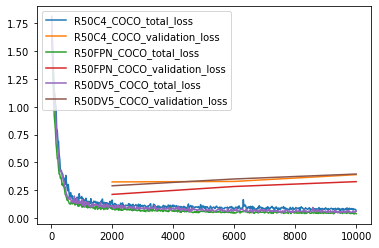

In [11]:
def load_json_arr(json_path):
    lines = []
    with open(json_path, "r") as f:
        for line in f:
            lines.append(json.loads(line))
    return lines


legends = []
for model, config in models_config.items():
    metrics = load_json_arr(os.path.join(config.OUTPUT_DIR, "metrics.json"))
    plt.plot([x["iteration"] for x in metrics], [x["total_loss"] for x in metrics])
    plt.plot(
        [x["iteration"] for x in metrics if "validation_loss" in x],
        [x["validation_loss"] for x in metrics if "validation_loss" in x],
    )
    legends.extend([f"{model}_total_loss", f"{model}_validation_loss"])
plt.legend(legends, loc="upper left")
plt.show()

# Visualize the result on validation set

Prediction result from model: R50C4_COCO
WARNING [07/28 10:02:21 d2.modeling.backbone.resnet]: ResNet.make_stage(first_stride=) is deprecated!  Use 'stride_per_block' or 'stride' instead.


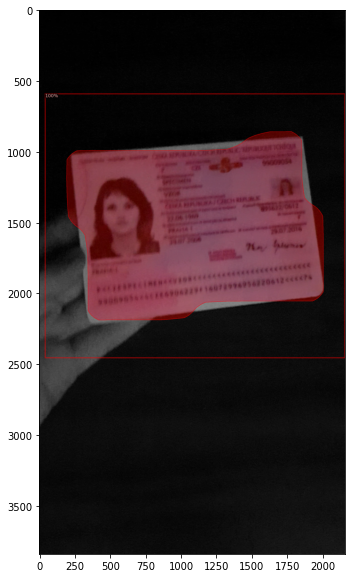

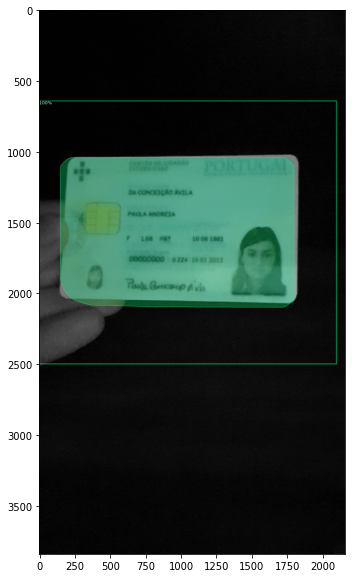

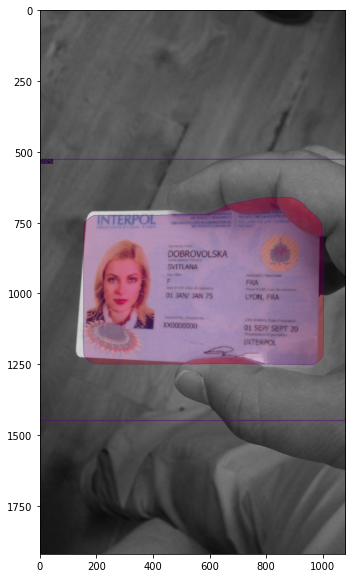

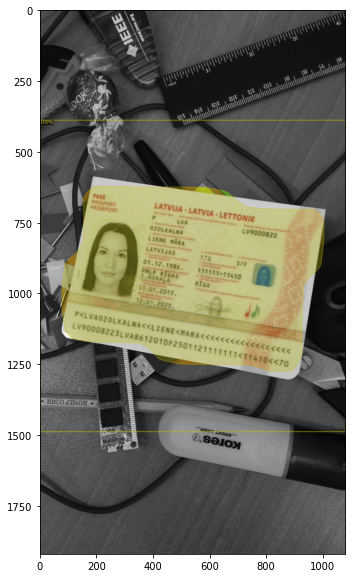

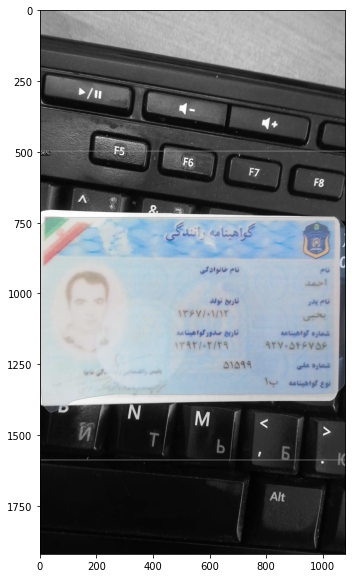

Prediction result from model: R50FPN_COCO


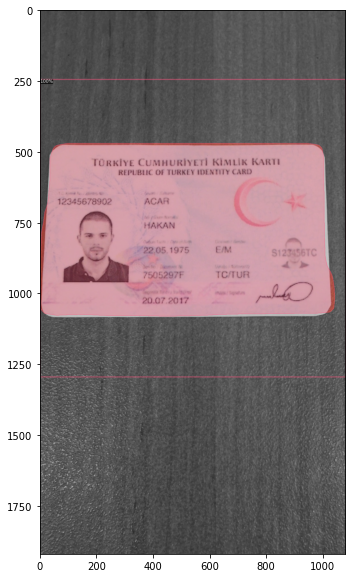

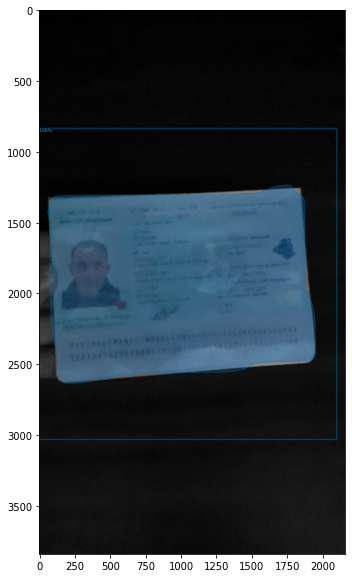

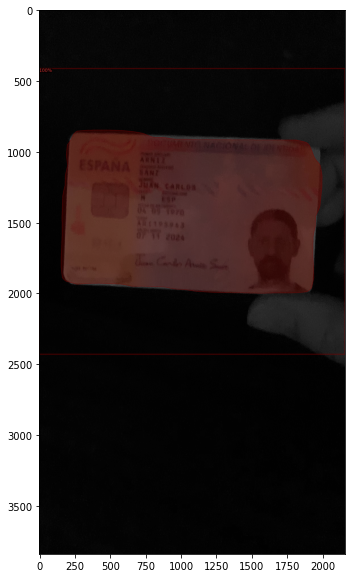

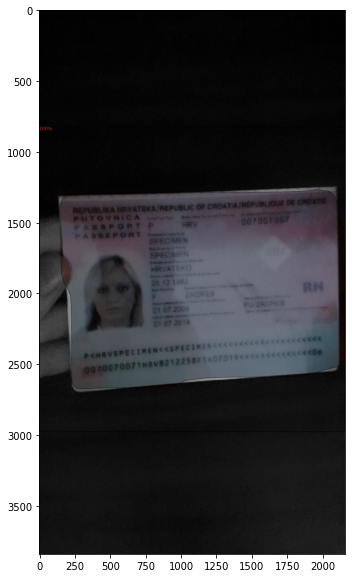

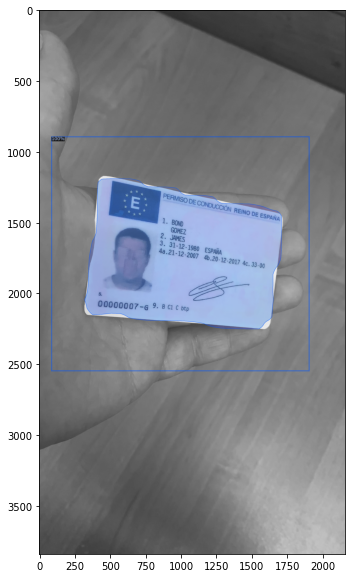

Prediction result from model: R50DV5_COCO


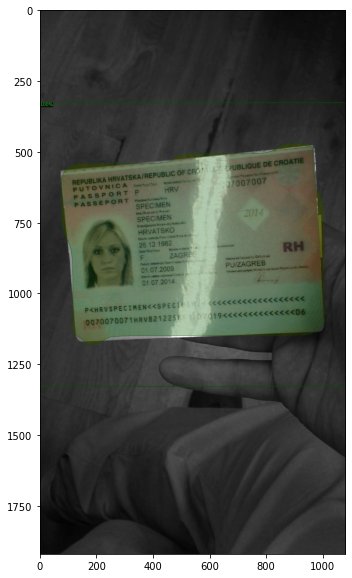

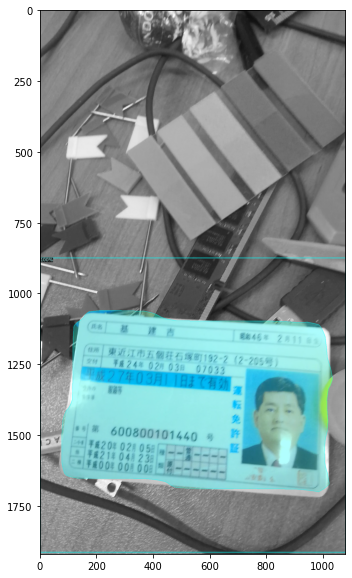

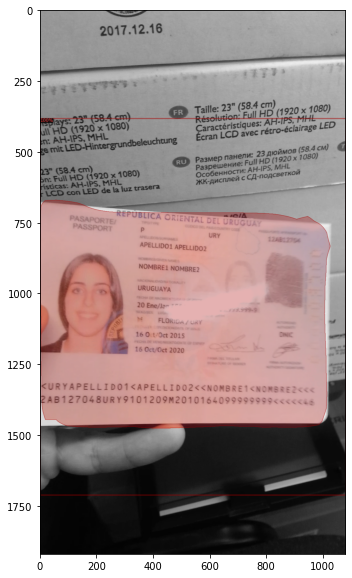

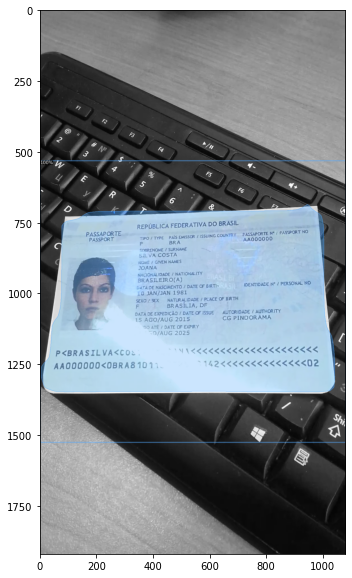

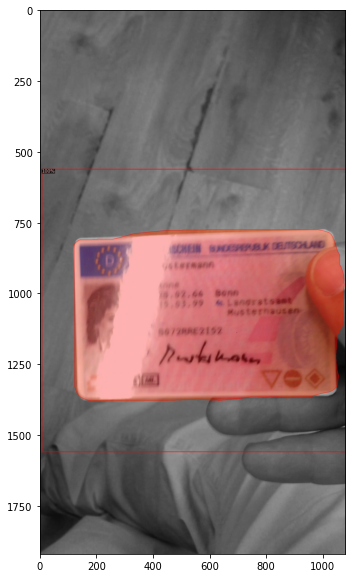

In [12]:
for model, config in models_config.items():
    print("Prediction result from model: {}".format(model))
    config.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    config.DATASETS.TEST = (f"{DATASET_NAME}_val",)
    
    predictor = DefaultPredictor(config)

    for d in random.sample(val_dataset_dicts, 5):
        im = cv2.imread(d["file_name"])
        outputs = predictor(im)
        v = Visualizer(
            im[:, :, ::-1],
            metadata=val_metadata,
            scale=1,
            instance_mode=ColorMode.IMAGE_BW,  # remove the colors of unsegmented pixels
        )
        v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        plt.figure(figsize=(14, 10))
        plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
        plt.show()

# Export VIDEO

In [51]:
# Load the test combination
src = "/data/card-segmentation/midv"
with open(os.path.join(src, "midv_test_combination.txt"), "r") as f:
    midv_test_comb = [line.strip() for line in f]

test_videos = []

for root, dirs, files in os.walk(src):
    if "videos" in root:
        for file in files:
            f = file[2:4] + file[:2]
            if f in midv_test_comb:
                test_videos.append(os.path.join(root, file))

# Choose 10 * 3 videos for demo randomly
random.shuffle(test_videos)
test_videos = test_videos[:10]

for model, cfg in models_config.items():
    cfg.defrost()
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
    cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.5
    cfg.MODEL.PANOPTIC_FPN.COMBINE.INSTANCES_CONFIDENCE_THRESH = 0.5
    cfg.freeze()

    for test_video in test_videos:
        mp.set_start_method("spawn", force=True)
        demo = VisualizationDemo(cfg)
        
        output_dir = os.path.join(src, "output", model)
        os.makedirs(output_dir, exist_ok=True)

        video = cv2.VideoCapture(test_video)
        width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
        frames_per_second = video.get(cv2.CAP_PROP_FPS)
        num_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT))
        basename = os.path.basename(test_video)

        output_fname = os.path.join(output_dir, basename)
        output_fname = os.path.splitext(output_fname)[0] + ".mp4"
        assert not os.path.isfile(output_fname), output_fname
        output_file = cv2.VideoWriter(
            filename=output_fname,
            fourcc=cv2.VideoWriter_fourcc(*"x264"),
            fps=float(frames_per_second),
            frameSize=(width, height),
            isColor=True,
        )

        for vis_frame in tqdm.tqdm(demo.run_on_video(video), total=num_frames):
            output_file.write(vis_frame)

        video.release()
        output_file.release()

WARNING [07/28 11:37:15 d2.modeling.backbone.resnet]: ResNet.make_stage(first_stride=) is deprecated!  Use 'stride_per_block' or 'stride' instead.


100%|██████████| 139/139 [00:37<00:00,  3.75it/s]


WARNING [07/28 11:37:55 d2.modeling.backbone.resnet]: ResNet.make_stage(first_stride=) is deprecated!  Use 'stride_per_block' or 'stride' instead.


100%|██████████| 144/144 [00:44<00:00,  3.22it/s]


WARNING [07/28 11:38:41 d2.modeling.backbone.resnet]: ResNet.make_stage(first_stride=) is deprecated!  Use 'stride_per_block' or 'stride' instead.


100%|██████████| 130/130 [00:37<00:00,  3.47it/s]


WARNING [07/28 11:39:20 d2.modeling.backbone.resnet]: ResNet.make_stage(first_stride=) is deprecated!  Use 'stride_per_block' or 'stride' instead.


100%|██████████| 125/125 [00:40<00:00,  3.05it/s]


WARNING [07/28 11:40:03 d2.modeling.backbone.resnet]: ResNet.make_stage(first_stride=) is deprecated!  Use 'stride_per_block' or 'stride' instead.


100%|██████████| 177/177 [01:08<00:00,  2.58it/s]


WARNING [07/28 11:41:12 d2.modeling.backbone.resnet]: ResNet.make_stage(first_stride=) is deprecated!  Use 'stride_per_block' or 'stride' instead.


100%|██████████| 142/142 [00:56<00:00,  2.50it/s]


WARNING [07/28 11:42:11 d2.modeling.backbone.resnet]: ResNet.make_stage(first_stride=) is deprecated!  Use 'stride_per_block' or 'stride' instead.


100%|██████████| 156/156 [00:46<00:00,  3.33it/s]


WARNING [07/28 11:42:59 d2.modeling.backbone.resnet]: ResNet.make_stage(first_stride=) is deprecated!  Use 'stride_per_block' or 'stride' instead.


100%|██████████| 357/357 [04:27<00:00,  1.34it/s]


WARNING [07/28 11:47:28 d2.modeling.backbone.resnet]: ResNet.make_stage(first_stride=) is deprecated!  Use 'stride_per_block' or 'stride' instead.


100%|██████████| 168/168 [00:46<00:00,  3.58it/s]


WARNING [07/28 11:48:16 d2.modeling.backbone.resnet]: ResNet.make_stage(first_stride=) is deprecated!  Use 'stride_per_block' or 'stride' instead.


100%|██████████| 322/322 [02:57<00:00,  1.81it/s]
